In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit, RepeatedStratifiedKFold, KFold, train_test_split 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import time

# 1) Data Loading and Preliminary Observations

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

shopping_data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Coursework_1_data.csv")

# Uncomment the below code and comment out the above if file will be directly uploaded to google colab. I used the above method 
# so I don't have to reupload the file each time I open the notebook.
# shopping_data = pd.read_csv("Coursework_1_data.csv") 
shopping_data.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [ ]:
shopping_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [ ]:
shopping_data.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

Great news! The dataset contains no missing data and is in tidy format which should make our work much easier. As a sanity check, let's also examine whether any duplicate rows are present.

Also, some of our qualitative data is encoded as int type/booleans. I'd prefer to change them to categorical type to make the data analysis easier, so I'll do that as well.

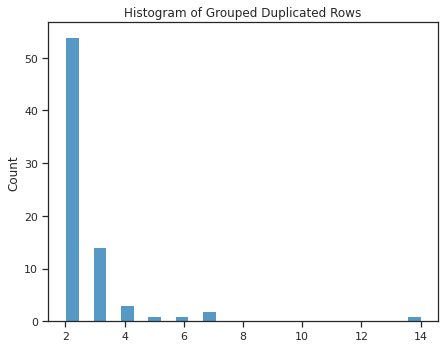

In [ ]:
sns.set_context("notebook")
sns.set_style('ticks')

for col in ["OperatingSystems", "Browser", "Region", "TrafficType", "VisitorType", "Month"]:
    shopping_data[col] = shopping_data[col].astype('category')
mapping = {True: "Weekend", False: "Not Weekend"}
shopping_data["Weekend"] = shopping_data["Weekend"].replace(mapping).astype('category')

plt.figure(figsize=(7, 5.5))

duplicates = shopping_data.duplicated(keep = False)
shopping_duplicates = shopping_data[duplicates].sort_values(list(shopping_data[duplicates].columns))
k = shopping_duplicates.value_counts(list(shopping_data[duplicates].columns)).values
duplicatesplot = sns.histplot(k)
duplicatesplot.set_title("Histogram of Grouped Duplicated Rows")
plt.show()

Although there are duplicated rows, they will not be dropped since customers might share the same instances especially in the case when the number of pages visited for each of adminstrative, informational, and product related categories are 0 (which is the case for all our duplicated rows anyway).

We can see from the above histogram that there are mostly 2-3 duplicate rows for each grouping, so the safe thing to do here is just not drop the duplicates.

In [ ]:
shopping_data.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000


There doesn't seem to be major issues with our numeric data at first glance apart from some obvious outliers in some of the duration variables. This will be looked in to more detail in the exploratory data analysis section.

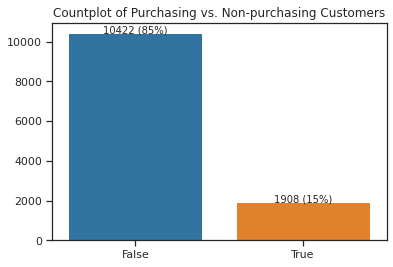

In [ ]:
labels=shopping_data['Revenue'].value_counts().index
values=shopping_data['Revenue'].value_counts().values
ax = sns.barplot(x=labels, y=values)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.15, "{} ({}%)".format(values[i], round((values[i]/sum(values))*100),2), ha="center", size = "small")
ax.set_title("Countplot of Purchasing vs. Non-purchasing Customers")
plt.show()

We can see that the proportion of customers who end up making a purchase (~ 15%) is much lower than those who do not (~ 85%). This tells us that our dataset is imbalanced and that our machine learning model should probably use stratified sampling to account for the difference in class labels. This will be done in section 3.

#2) Exploratory Data Analysis

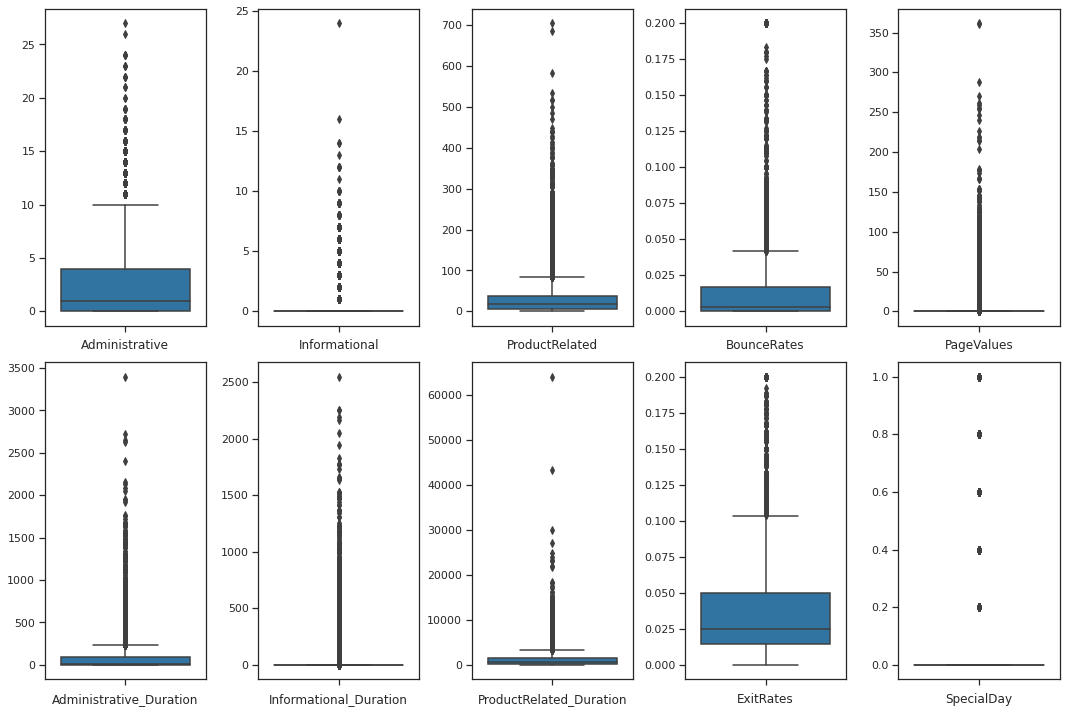

In [ ]:
# Boxplots for all quantitative variables 
fig, ax = plt.subplots(2, 5, figsize = (15,10))
fig.tight_layout()
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_columns = shopping_data.select_dtypes(include=numerics)
m = 0
for i in range(5):
  for j in range(2):
    g = sns.boxplot(y = num_columns.columns.tolist()[m], data = shopping_data, ax = ax[j, i])
    g.set(xlabel = num_columns.columns.tolist()[m], ylabel = None)
    m += 1
plt.show()

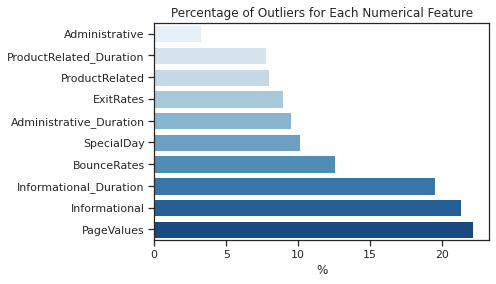

In [ ]:
# Checking for % of outliers in each column using IQR method
Q1 = num_columns.quantile(0.25)
Q3 = num_columns.quantile(0.75)
IQR = Q3 - Q1
count_outliers = (num_columns < (Q1 - 1.5 * IQR)) |(num_columns > (Q3 + 1.5 * IQR))
count_dict = {}

for col in count_outliers.columns:
  count_dict[col] = (count_outliers[col].value_counts()[True] / (count_outliers[col].value_counts()[True] + count_outliers[col].value_counts()[False]))* 100

outliers_df = pd.DataFrame(list(count_dict.items()))
outliers_df.columns = ["Variable", "Percentage"]
outliers_df = outliers_df.sort_values("Percentage")

outliers_plot = sns.barplot(y = "Variable", x = "Percentage", data = outliers_df, palette = "Blues")
outliers_plot.set(ylabel = None, xlabel = "%")
outliers_plot.set_title("Percentage of Outliers for Each Numerical Feature")
plt.show()

In [ ]:
#Getting dimension of resulting dataframe with all outliers dropped and comparing it with original
num_columns_no_outliers = num_columns[~((num_columns < (Q1 - 1.5 * IQR)) |(num_columns > (Q3 + 1.5 * IQR))).any(axis=1)]
print(num_columns_no_outliers.shape[0], num_columns.shape[0])

5258 12330


Firstly, dropping the outliers completely using the IQR method is out of the question as that would eliminate more than half our instances. 

Now, even though the data seems to have a lot of outliers that should probably be dealt with, the following key points should be noted:

1.   Apart from specifc numeric variables like product, product-related duration, and page values, outliers for other variables are within the scope of acceptable reason. The outliers for the latter categories probably have to do with the proprotion of people who spend time on the site vs. those that who do not.
2.   The concerning outliers are mainly in the following three variables: product, product-related duration, and page values. Does it really make sense for the total amount of time spent by a visitor on product related pages to exceed 20,000 hours (5.56 hours)? Also, will a visitor actually visit anywhere between 200 to 700 pages or could these instances be related to a scrapper? 

Without having access to any historical data or contact with the people who designed this dataset, I will not be dropping any instances mostly because I believe product-related variables and page values will be important features and having as many instances as possible to train/test our models will be beneficial. 

However, I will set a 20,000 seconds upper limit for product-related duration when I define the pipeline for the ML model.

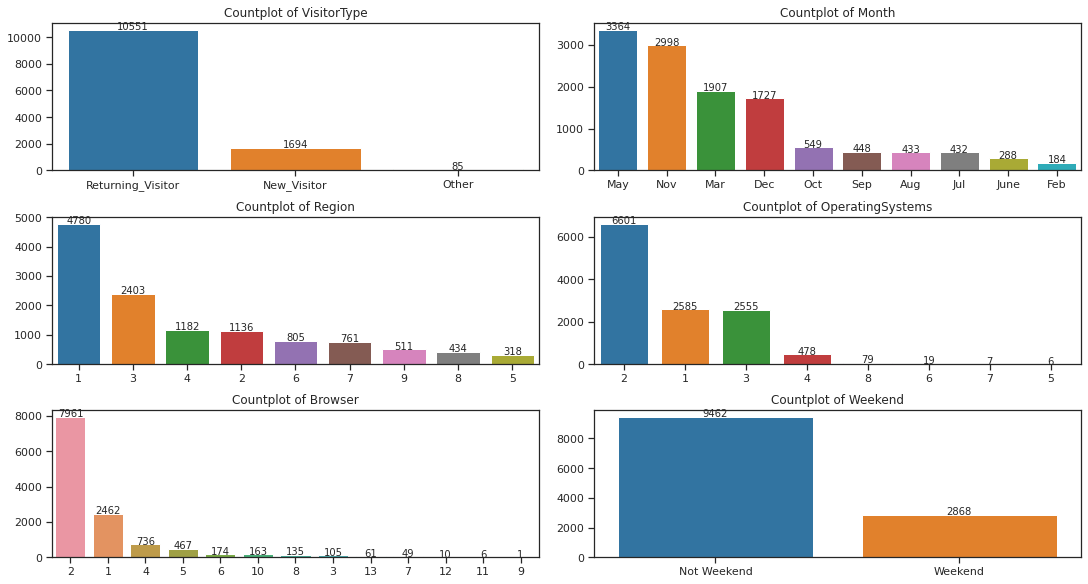

In [ ]:
# Countplot for categorical variables 
categories_to_plot = ["VisitorType", "Month", "Region", "OperatingSystems", "Browser", "Weekend"]

fig, ax = plt.subplots(3, 2, figsize = (15,8), constrained_layout=True)
m = 0
for i in range(3):
  for j in range(2):
    labels=shopping_data[categories_to_plot[m]].value_counts().index
    values=shopping_data[categories_to_plot[m]].value_counts().values
    g = sns.countplot(x = shopping_data[categories_to_plot[m]], data = shopping_data, 
                      ax = ax[i, j], order = shopping_data[categories_to_plot[m]].value_counts().index)
    g.set(xlabel = None, ylabel = None)
    g.set_title("Countplot of {}".format(categories_to_plot[m]))
    for k, p in enumerate(g.patches):
      height = p.get_height()
      g.text(p.get_x()+p.get_width()/2., height + 0.15, values[k], ha="center", size = "small")
    m += 1
plt.show()

In [ ]:
#Check for number of unique values within each category
shopping_data.select_dtypes(include=['category']).apply(pd.Series.nunique, axis = 0)

Month               10
OperatingSystems     8
Browser             13
Region               9
TrafficType         20
VisitorType          3
Weekend              2
dtype: int64

We're missing data for both January and April! While this won't affect us when we run our ML models on the test/train sets, I highly doubt this model will be able to generalize well to newer data if January/April are present in a future dataset. What I'll be doing is dividing the months in to quarters. Once again, I won't do the dataframe modifications here as they'll conducted  in section 3. 

In [ ]:
# One last sanity check for categorical variables
shopping_data.select_dtypes(include=['category']).apply(pd.Series.unique, axis = 0)

Month               ['Feb', 'Mar', 'May', 'Oct', 'June', 'Jul', 'A...
OperatingSystems    [1, 2, 4, 3, 7, 6, 8, 5]
Categories (8, int64)...
Browser             [1, 2, 3, 4, 5, ..., 8, 9, 12, 13, 11]
Length:...
Region              [1, 9, 2, 3, 4, 5, 6, 7, 8]
Categories (9, int...
TrafficType         [1, 2, 3, 4, 5, ..., 18, 19, 16, 17, 20]
Lengt...
VisitorType         ['Returning_Visitor', 'New_Visitor', 'Other']
...
Weekend             ['Not Weekend', 'Weekend']
Categories (2, obje...
dtype: object

Nothing really jumps out as concerning here apart from the Months. Unfortuantely, most of the categorical variables are encoded as int which will detract from some of the data analysis. There are no str errors/illogical values within each category, so there's no need to do any data cleaning here.

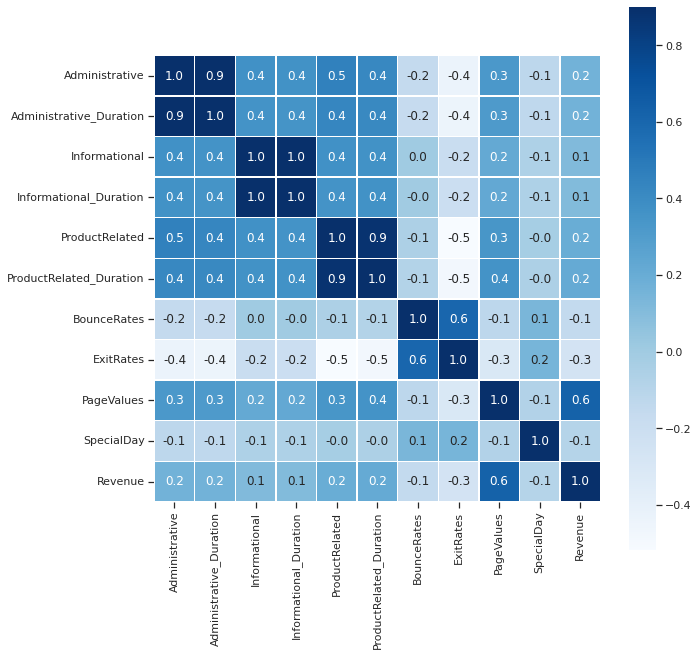

In [ ]:
spearmanCorr = shopping_data.corr(method = "spearman")
plt.figure(figsize=(10,10))
sns.heatmap(spearmanCorr, vmax=0.9, square=True, annot=True, cmap = "Blues",linewidths=0.3, fmt=".1f")

correlations = shopping_data.corr(method = "spearman")['Revenue'].sort_values()

In [ ]:
correlations

ExitRates                 -0.254488
BounceRates               -0.148977
SpecialDay                -0.086878
Informational_Duration     0.112120
Informational              0.113876
Administrative_Duration    0.163960
Administrative             0.167945
ProductRelated             0.198545
ProductRelated_Duration    0.216764
PageValues                 0.626363
Revenue                    1.000000
Name: Revenue, dtype: float64

In general, not many features have that much of a strong correlation with revenue apart from pagevalues and product related duration (positive, confirming my suspicions above) along with exit rates and bounce rates (negative). These features might be especially useful for our ML models, but without running anything we can't know for sure yet. I suspect page values will be one of our most important features, but for now let's run some other analysis.  

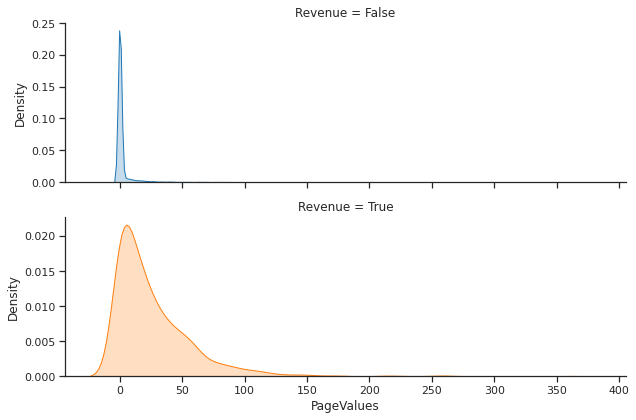

In [ ]:
g = sns.FacetGrid(shopping_data, row="Revenue", hue = "Revenue",
                  height=3, aspect = 3, sharey = False)
g.map(sns.kdeplot, "PageValues", shade = True)
plt.show()

From the above kde plots, it's obvious that the page values feature does have a significant impact on whether a customer finalizes his/her visit with a transaction or not. In general, an overwhelming majority of customers who do not make a purchase had page values close to 0 while this trend was not observed in customers who made a purchase with page values being more spread out for values greater than 0. 

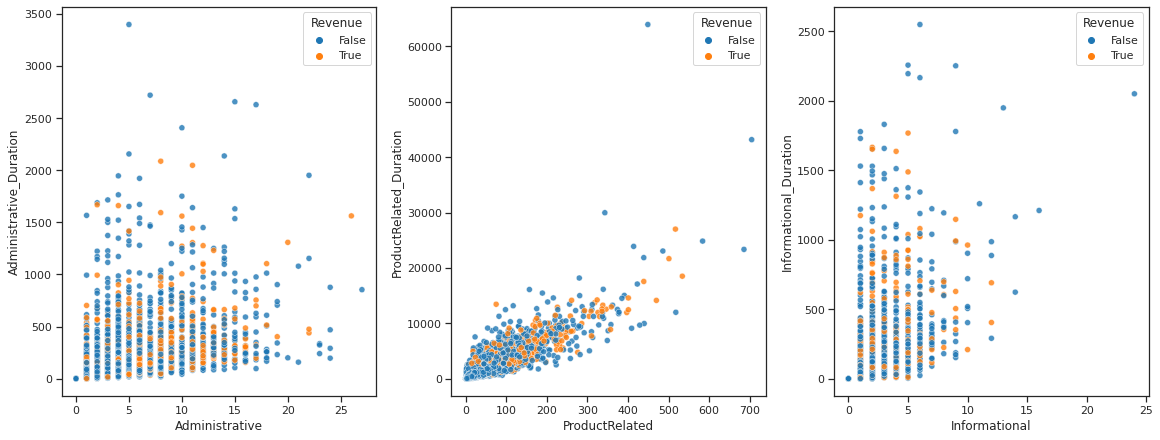

In [ ]:
scatter_variables = [["Administrative", "Administrative_Duration"], ["ProductRelated" , "ProductRelated_Duration"], ["Informational", "Informational_Duration"]]
fig, ax = plt.subplots(1, 3, figsize = (16,6), constrained_layout = True)

m = 0
for i in scatter_variables:
  sns.scatterplot(x = i[0], y = i[1], hue = "Revenue", data = shopping_data, alpha = 0.8, ax = ax[m])
  m += 1

In [ ]:
#Checking for inconsistencies between number of pages visited and total time spent for each category
print(shopping_data.loc[(shopping_data["ProductRelated"] >= 4) & (shopping_data["ProductRelated_Duration"] == 0), 
                  ["ProductRelated", "ProductRelated_Duration"]].sort_values("ProductRelated", ascending = False))
print(shopping_data.loc[(shopping_data["Administrative"] >= 4) & (shopping_data["Administrative_Duration"] == 0), 
                  ["Administrative", "Administrative_Duration"]].sort_values("Administrative", ascending = False))
print(shopping_data.loc[(shopping_data["Informational"] >= 4) & (shopping_data["Informational_Duration"] == 0), 
                  ["Informational", "Informational_Duration"]].sort_values("Informational", ascending = False))


       ProductRelated  ProductRelated_Duration
2323               13                      0.0
5109               11                      0.0
2435               10                      0.0
4349                9                      0.0
2393                9                      0.0
7642                7                      0.0
6375                6                      0.0
12321               6                      0.0
2896                5                      0.0
5378                5                      0.0
9557                5                      0.0
5657                5                      0.0
6577                5                      0.0
4799                5                      0.0
2276                5                      0.0
831                 4                      0.0
4954                4                      0.0
2151                4                      0.0
3490                4                      0.0
6923                4                      0.0
7185         

In general, productrelated and productrelated duration have some slight degree of linearity between them whereby as one increases the other tends to do so as well. Moreover, while the relationship is not that profound, customers seem to be more inclined to make a purchase when productrelated/productrelated duration increases which gives us another hint regarding the importance of these features in our ML model. 

One important thing to note here is that there are some anomalies in our dataset. If we filter by productrelated being greater than or equal to 4 pages and productrelated duration to be 0, we can see that some instances actually do have these values present! Even if we account for the fact that productrelated duration was rounded (which explains so many 0's being present), it still doesn't make sense for someone to visit 13 pages related to products and spending a total amount of time of 0 without a scrapper being involved. Once again, if this was my data, I would definitely drop any instances having more than 4 pages visited and 0 total amount of time spent, but since I'm not sure what went through the design of this dataset/data input methodology, I will not be dropping these instances. 

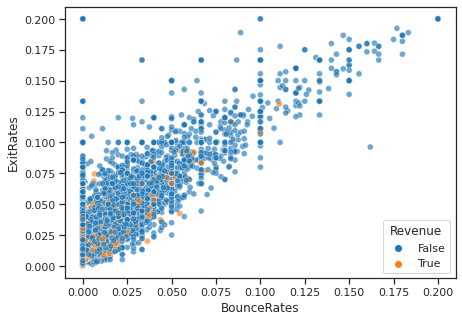

In [ ]:
fig, ax = plt.subplots(figsize = (7,5))
sns.scatterplot(x = "BounceRates", y = "ExitRates", hue = "Revenue", data = shopping_data, alpha = 0.65)
plt.show()

Some linearity can be observed between exit rates and bounce rates, but the more important thing to note here is that customers who do make a purchase tend to have much lower values for exit/bounce rates which might give an indication as to the importance of these two variables in predicting customers who do not make a purchase.

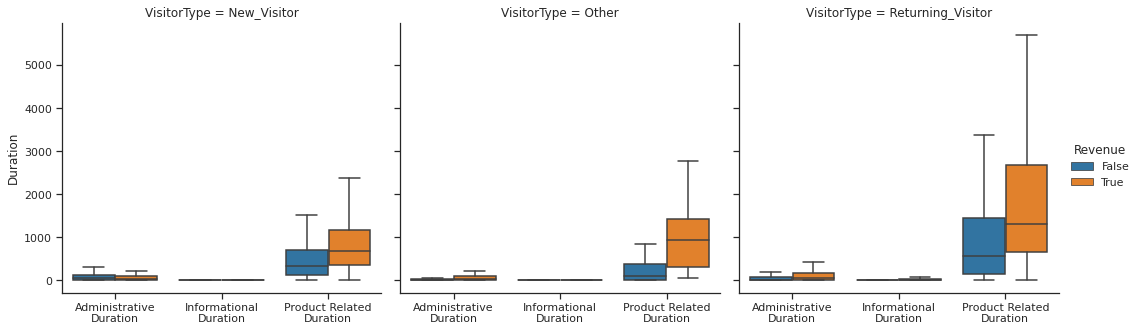

In [ ]:
total_timedf = shopping_data.loc[:,["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration", "VisitorType", "Revenue"]]
total_timedflong = pd.melt(total_timedf, id_vars = ["VisitorType", "Revenue"])
mapping = {"Administrative_Duration":"Administrative\nDuration", "Informational_Duration":"Informational\nDuration",  "ProductRelated_Duration":"Product Related\nDuration"}
total_timedflong["variable"] = total_timedflong["variable"].replace(mapping)

durational_boxplots = sns.catplot(x = "variable", y = "value", data = total_timedflong, 
                                  hue = "Revenue", col = "VisitorType", kind = "box", sym = "")
durational_boxplots.set(xlabel = None, ylabel = "Duration")
plt.show()

The above boxplots show a similar trend among all customer types (apart from adminstrative duration for new visitors with these types of visitors having a higher median time spent on adminstrative duration when they don't make a purchase). Also, please note that outliers were masked for above boxplots otherwise it'll be very difficult to visually observe the difference across customer types. 

The most significant one appears to be the product related duration feature with most customers spending a significant part of their time on product related pages. In addition, customers who do end up making a purchase tend to spend more time on product-related pages compared to those who do not.  

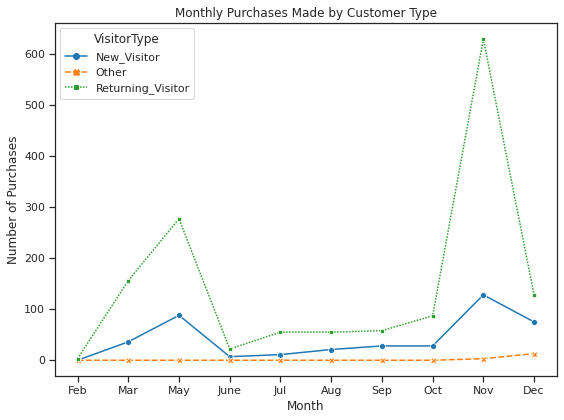

In [ ]:
df = shopping_data.value_counts(["Month", "Revenue","VisitorType"]).reset_index(name='counts')
df['Month'] = pd.Categorical(df['Month'],
                                   categories=['Feb', 'Mar', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                                   ordered=True)

df = df.set_index(['Month','Revenue', 'VisitorType'])
mux = pd.MultiIndex.from_product([df.index.levels[0], df.index.levels[1], df.index.levels[2]],names=['Month','Revenue', 'VisitorType'])
df = df.reindex(mux, fill_value=0).reset_index()

plt.figure(figsize=(9, 6.5))
g = sns.lineplot(x = "Month", y = "counts", hue = "VisitorType", data = df.loc[df["Revenue"] == True,], 
            style = "VisitorType", markers = True)
g.set_title("Monthly Purchases Made by Customer Type")
g.set(xlabel = "Month", ylabel = "Number of Purchases")
plt.show()

In terms of monthly purchases made by customers, a significant portion of those were made in November and May with these figures having similar peaks/trends for returning and new customers. This gives us a good indication that these two months will have some form of impact on predicting whether a customer ends up making a purchase or not. Interestingly enough, "other" visitor types seem to only make purchases during November and December (in all other months, 0 purchases were made for said visitiors, but the plot was constructed to show 0's for those months as well) 

#3) Pipeline Creation and ML Models



##3.1 - Baseline Models (Stratified Sampling)

In [ ]:
label_enc = LabelEncoder()
shopping_data["Revenue"] = label_enc.fit_transform(shopping_data["Revenue"])

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(shopping_data, shopping_data["Revenue"]):
    strat_train_set = shopping_data.loc[train_index]
    strat_test_set = shopping_data.loc[test_index]

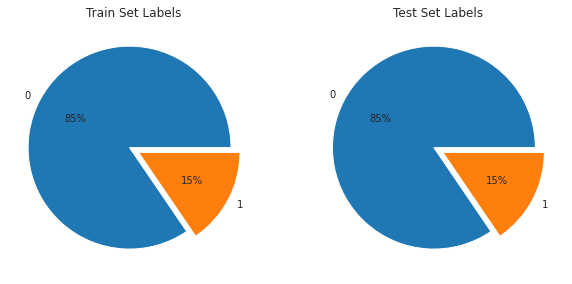

In [ ]:
#Some sanity checks to make sure proportion of train/test data matches the original
train_prop = strat_train_set.value_counts("Revenue")
test_prop = strat_test_set.value_counts("Revenue")

labels_train = train_prop.index
labels_test = train_prop.index

fig, ax = plt.subplots(1, 2, figsize = (10,10))
ax[0].pie(x = train_prop, autopct="%.f%%", explode=[0.05]*2,labels=labels_train, textprops={'fontsize': 10})
ax[1].pie(x = test_prop, autopct="%.f%%", explode=[0.05]*2, labels=labels_test, textprops={'fontsize': 10})
ax[0].set_title("Train Set Labels")
ax[1].set_title("Test Set Labels")
plt.show()

In [ ]:
#Function for pipeline definition and fiting models

num_attribs = shopping_data.select_dtypes(include=np.number).columns.tolist()
num_attribs.remove("Revenue")
cat_attribs = shopping_data.select_dtypes(include=['category']).columns.tolist()

def model_pipeline(model, scaler, crossval = False, confusion = False):
  '''
  This function returns train/test/ (optional) cross-validated metrics (accuracy, recall, precision, f1) for a given
  classification model. Also returns confusion matrix if specified by the user.

  IMPORTANT NOTE (READ ME):
    -> Keep crossval as False if you'd like to significantly speed up the run-time of the notebook.
    I've set it to True as I require the cross-validated scores in addition to the test scores.

  Args:

  -Required:
  model: ML classification model to fit (example: SVC(randomstate = 42))

  -Optional:
  crossval: boolean specifying whether cross-validation should also be conducted. Default is no cross-validation.
  confusion: boolean specifying whether confusion matrix should be returned. Default is no confusion matrix.

  Returns:
  -If cross val is False:
    -> Performance metrics for train/test set as a dictionary with keys: Classification Model, Test Scores, and Train Scores
  -If cross val is True:
    -> Performance metrics for train/test set and 10-fold stratified cross-validated scores as a dictionary with keys: 
    Classification Model, Test Scores, Train Scores, Cross Validated Mean Scores, and Cross Validated SD Scores
  -If confusion is True:
    -> Returns one of the two dictionaries above as well as the confusion matrix (depending on whether crossval is turned or off)
  '''
  num_pipeline = Pipeline([
          ('scaler', scaler),
      ])
  cat_pipeline = Pipeline([
          ('hot', OneHotEncoder(sparse = False)),
      ])

  preprocessor = ColumnTransformer([
          ("num", num_pipeline, num_attribs),
          ("cat", cat_pipeline, cat_attribs),
      ])
  classifierpipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])
  
  classifierpipe.fit(X_train, y_train)
  y_predict_test = classifierpipe.predict(X_test)
  y_predict_train = classifierpipe.predict(X_train)
  c_matrix = confusion_matrix(y_test, y_predict_test)

  if crossval is True:
    transformed_train = preprocessor.fit_transform(X_train)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = ["accuracy", "recall", "precision", "f1"]
    cross_scores = cross_validate(model, transformed_train, y_train, cv = cv, scoring = scores)
    results_dict_cross = {"Classification Model":model.__class__.__name__, 
                  "Test Scores":{"Accuracy":accuracy_score(y_test, y_predict_test), "Recall":recall_score(y_test, y_predict_test), 
                          "Precision":precision_score(y_test, y_predict_test), "F1":f1_score(y_test, y_predict_test)}, 
                  "Train Scores":{"Accuracy":accuracy_score(y_train, y_predict_train), "Recall":recall_score(y_train, y_predict_train), 
                           "Precision":precision_score(y_train, y_predict_train), "F1":f1_score(y_train, y_predict_train)},
                  "Cross Validated Mean Scores": {"Accuracy":np.mean(cross_scores["test_accuracy"]),
                                       "Recall": np.mean(cross_scores["test_recall"]),
                                       "Precision": np.mean(cross_scores["test_precision"]),
                                       "F1": np.mean(cross_scores["test_f1"])},
                  "Cross Validated SD Scores": {"Accuracy":np.std(cross_scores["test_accuracy"]),
                                          "Recall": np.std(cross_scores["test_recall"]),
                                          "Precision": np.std(cross_scores["test_precision"]),
                                          "F1": np.std(cross_scores["test_f1"])}}
    if confusion is False:
      return results_dict_cross
    else:
      return results_dict_cross, c_matrix
  else:
    results_dict = {"Classification Model":model.__class__.__name__, 
                  "Test Scores":{"Accuracy":accuracy_score(y_test, y_predict_test), "Recall":recall_score(y_test, y_predict_test), 
                          "Precision":precision_score(y_test, y_predict_test), "F1":f1_score(y_test, y_predict_test)}, 
                  "Train Scores":{"Accuracy":accuracy_score(y_train, y_predict_train), "Recall":recall_score(y_train, y_predict_train), 
                           "Precision":precision_score(y_train, y_predict_train), "F1":f1_score(y_train, y_predict_train)}}
    if confusion is False:
      return results_dict
    else:
      return results_dict, c_matrix

In [ ]:
def plot_confusionMatrix(cm):
  """
  Simple confusion matrix plotter for fitted models.
  """
  fig, ax = plt.subplots(1, len(cm), figsize = (30,6))

  for i in range(len(cm)):
    df_cm = pd.DataFrame(cm[i][1], index = ["Did not purchase", "Made a purchase"], columns = ["Did not purchase", "Made a purchase"])
    g = sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap = "Blues", fmt = "g", ax = ax[i])
    g.set_title("Confusion Matrix for {}".format(cm[i][0]))
    g.set(xlabel = "Prediction", ylabel = "Truth")

  plt.show()

In [ ]:
def plot_scores(df_list, title, add_to_final_scores = False):
  """
  Basic performance metric plotter function for fitted models. Plots accuracy, recall, precision, and f1
  scores for each model on test/train set along with cross-validated mean performance metrics.

  if add_to_final_scores is set to True, the function adds a dataframe of results to a dictionary called
  merged_scores for a future final results comparison. 
  """
  scores_df = [pd.DataFrame.from_dict(df_list[k]).reset_index() for k in range(len(df_list))]
  plot_scores_df = pd.concat(scores_df)
  plot_scores_df.rename(columns={'index':'Performance Metric'}, inplace=True)
  plot_scores_df.sort_values(["Performance Metric", "Classification Model"])

  if set(['Cross Validated Mean Scores','Cross Validated SD Scores']).issubset(plot_scores_df.columns):
    scores_to_plot = ["Test Scores", "Train Scores", "Cross Validated Mean Scores"]
    m = 3
    fig, ax = plt.subplots(1, m, figsize = (35,6))
  else:
    scores_to_plot = ["Test Scores", "Train Scores"]
    m = 2
    fig, ax = plt.subplots(1, m, figsize = (27,6))  

  for i in range(m):
    values = list(plot_scores_df[scores_to_plot[i]])
    g = sns.barplot(x = "Performance Metric", y = scores_to_plot[i], data = plot_scores_df, hue = "Classification Model", ax = ax[i])
    g.set(ylabel = None, xlabel = None)
    g.set_title(scores_to_plot[i], fontsize = 18, y = -0.15)    
    for k, p in enumerate(g.patches):
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2., height, round(values[k],3), ha="center", size = 14)
    for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
      label.set_fontsize(16)
    if i < m-1:
      ax[i].get_legend().remove()
    else:
      plt.legend(bbox_to_anchor=(1.48, 0.65), fontsize = 16)

  fig.suptitle(title, fontsize = 20)
  plt.show()

  plot_scores_df["Type"] = title 
  
  if add_to_final_scores:
    merged_scores[title] = plot_scores_df

In [ ]:
#Get Xtrain, ytrain, Xtest, ytest for baseline models and fit on them

X_train = strat_train_set.drop("Revenue", axis = 1)
y_train = strat_train_set["Revenue"]
X_test = strat_test_set.drop("Revenue", axis = 1)
y_test = strat_test_set["Revenue"]

In [ ]:
#Classifiers to be tested
rnd_clf = model = RandomForestClassifier(random_state = 42)
svc_clf = SVC(random_state=42)  
knn_clf = KNeighborsClassifier()

In [ ]:
# Initiate dictionary to store dataframes containing performance metrics for best fitted models.
# This will be used in section 4 to construct a final results comparsion pivot table
merged_scores = {}

### 3.1.1 - Using Standard Scaler

In [ ]:
baseline_scores_list = []
baseline_cm_list = []
for clf in (svc_clf, knn_clf, rnd_clf):
  base_model_dict, base_model_cmatrix = model_pipeline(clf, scaler = StandardScaler(), crossval = True, confusion = True)
  baseline_scores_list.append(base_model_dict)
  baseline_cm_list.append((base_model_dict["Classification Model"], base_model_cmatrix))

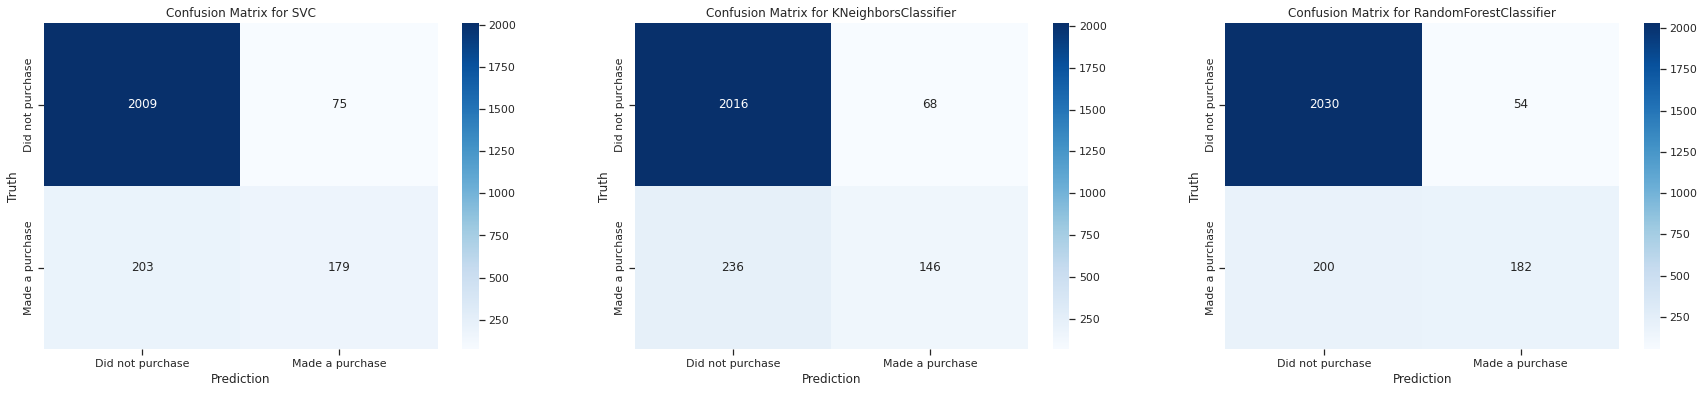

In [ ]:
plot_confusionMatrix(baseline_cm_list)

Well, that's just terrible...
Some major common themes jump out here:

1) For SVC:

Only 179 (46.85%) of the 382 customers that actually made a purchase were correctly identified. This statistic was better for customers who did not make a purchase with 2009 (96.4%) out of the 2084 customers being correctly classified.

2) For KNN:

Only 146 (38.22%) of the 382 customers that actually made a purchase were correctly identified. This statistic was better for customers who did not make a purchase with 2016 (96.7%) out of the 2084 customers being correctly classified.

3) For Random Forest:

Only 182 (47.64%) of the 382 customers that actually made a purchase were correctly identified. This statistic was better for customers who did not make a purchase with 2030 (97.4%) out of the 2084 customers being correctly classified.

In other words, all three models did a terrible job at correctly predicting the customers who actually end up making a purchase (less than 50% for all 3) with KNN being the "worst" performing model!


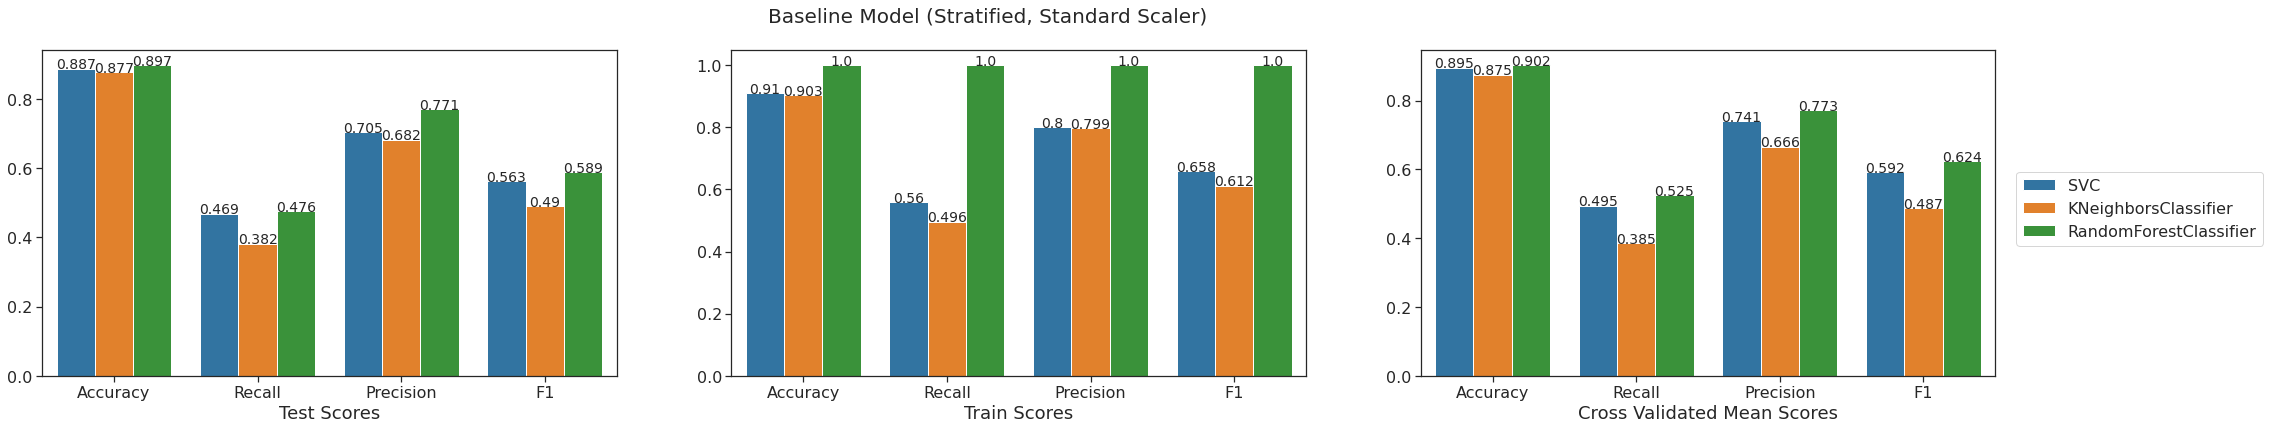

In [ ]:
plot_scores(baseline_scores_list, "Baseline Model (Stratified, Standard Scaler)", add_to_final_scores=True)

###3.1.2 - Using Log Transformation

In [ ]:
baseline_scores_log_list = [model_pipeline(clf, FunctionTransformer(np.log1p), crossval = True) for clf in (svc_clf, knn_clf, rnd_clf)]

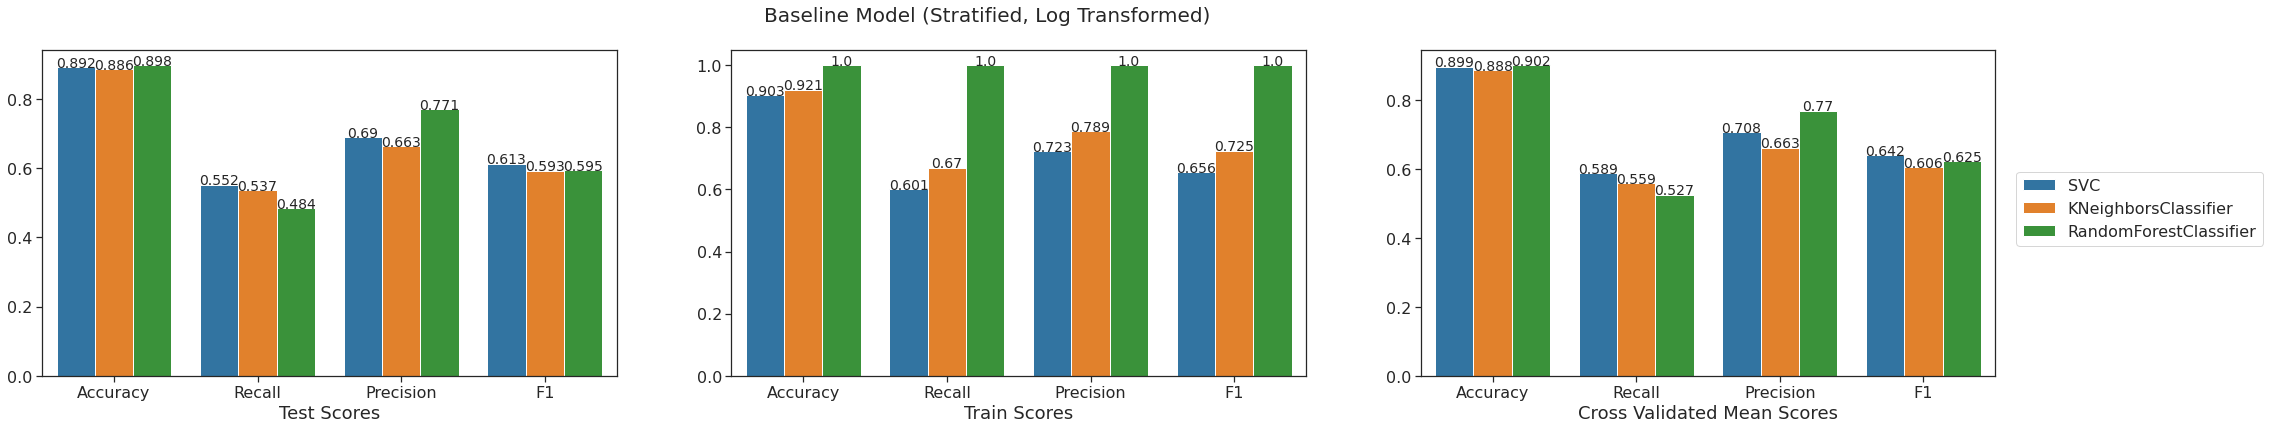

In [ ]:
plot_scores(baseline_scores_log_list, "Baseline Model (Stratified, Log Transformed)", add_to_final_scores=True)

Looks like applying a log transformation instead of using the standard scaler did a relatively better job at catching customers who actually end up making a purchase. 

Our recall increased whereby previously each of SVC, KNN, and Random Forest classifiers were only able to correctly classify 46.85%, 38.22%, and 47.64% of customers who make a purchase. With a log transformation, these figures went up to 55.2%, 53.7%, and 48.4%, respectively which is a decent improvement, but we might be able to do better (will be attempted in later sections).

It's worth noting that for both standard scaled and log transformed data, the cross-validated and test set accuracies were relatively fine (87% and upwards for both cases), but accuracy isn't that really good of a performance metric for this problem since we have such an imbalanced class distribution. 

One important thing to note is that the random forest classifier has perfect scores on the training set! This might mean our model might be overfitting, but let's run some hyperparameter searches to try to fix that.

In [ ]:
def get_best_features_rnd(scaler):
  """
  This function ranks the feature importance of a fitted random forest classifer
  """    
  num_pipeline = Pipeline([
          ('scaler', scaler),
      ])
  cat_pipeline = Pipeline([
          ('hot', OneHotEncoder(sparse = False)),
      ])

  preprocessor = ColumnTransformer([
          ("num", num_pipeline, num_attribs),
          ("cat", cat_pipeline, cat_attribs),
      ])

  X_train_prep = preprocessor.fit_transform(X_train)
  X_test_prep = preprocessor.transform(X_test)
  rnd_clf.fit(X_train_prep, y_train)
  rnd_clf.predict(X_test_prep)

  return rnd_clf.feature_importances_

def categoric_names_after_one_hot(scaler, model):

  """
  This function returns the name of categoric columns after one hot encoding.
  Will be used to determine what feature names are associated with random forest
  classifier feature importances.
  """
    
  num_pipeline = Pipeline([
          ('scaler', scaler),
      ])
  cat_pipeline = Pipeline([
          ('hot', OneHotEncoder(sparse = False)),
      ])

  preprocessor = ColumnTransformer(transformers = [
          ("num", num_pipeline, num_attribs),
          ("cat", cat_pipeline, cat_attribs),
      ])
  
  classifierpipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])
  
  classifierpipe.fit(X_train, y_train)
  names = classifierpipe['preprocessor'].transformers_[1][1]['hot']\
                   .get_feature_names_out(cat_attribs)


  return names

feature_imp = get_best_features_rnd(StandardScaler())

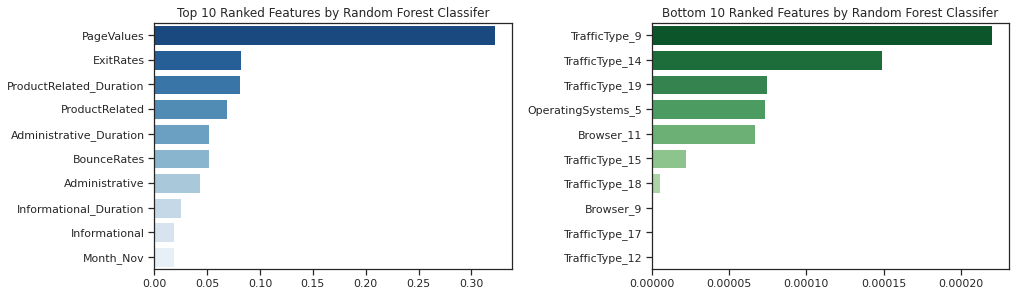

In [ ]:
one_hot_names = list(categoric_names_after_one_hot(StandardScaler(), rnd_clf))
nums = num_attribs.copy()
joined_names = nums + one_hot_names

imp_df = pd.DataFrame.from_dict({'Variable' : joined_names, 'Importance' : feature_imp}, orient='index').T
bottom_10 = imp_df.sort_values("Importance", ascending = True).iloc[0:10, :]
top_10 = imp_df.sort_values("Importance", ascending = False).iloc[0:10, :]

fig, ax = plt.subplots(1,2, figsize = (14, 4), constrained_layout = True)

topg = sns.barplot(x = "Importance", y = "Variable", data = top_10, ax = ax[0], palette="Blues_r")
topg.set_title("Top 10 Ranked Features by Random Forest Classifer")
topg.set(xlabel = None, ylabel = None)
bottomg = sns.barplot(x = "Importance", y = "Variable", data = bottom_10.sort_values("Importance", ascending = False), 
                      ax = ax[1], palette = "Greens_r")
bottomg.set(xlabel = None, ylabel = None)
bottomg.set_title("Bottom 10 Ranked Features by Random Forest Classifer")
plt.show()

###3.1.3 - Hyperparameter Tuning

Let's try to optimize our hyperparameters using GridSearchCV and see if we obtain better results. A couple of notes to make here:


1.   These take a long time to run (had to run on two PCs to speed up runtime), so I will be commenting out the code that gets the optimal hyperparameters and just write down the results. Also, I'm not sure if this is correct, but google colab felt much slower in getting hyperparameters compared to running from command prompt. I tried setting runtime to GPU in colab, but it didn't help.
2.   I've decided to use an f1 scoring as my metric of choice when running a grid/random search. The reason I've decided to do so is that it gives us a well balanced trade-off between recall and precision and should do a good enough job for our dataset. Now, if it were up to me and this was my own business, I would have definitely chosen to optimize recall instead, but since I don't have any contact with the business owners and I'm not really sure what their specific objective is (reducing false negatives or false positives) I think f1 should be a safe choice. 
3. Hyperparameters will be tuned for both standard scaled and log transformed data.

In [ ]:
#Just for fun, let's plot the accuracy of KNN using different values for the number of neighbors parameter.
#We'll be using Grid Search/Random Search Cross Validation next to optimize hyperparameters for all models used.
#For reference, only odd # of neighbors will be tested since we have a two class problem

accuracy_scores_knn = {"Train":{}, "Test":{}}
for i in range(1, 40, 2):
  results = model_pipeline(KNeighborsClassifier(n_neighbors = i), FunctionTransformer(np.log1p))
  accuracy_scores_knn["Train"][i] = results["Train Scores"]["Accuracy"]
  accuracy_scores_knn["Test"][i] = results["Test Scores"]["Accuracy"]

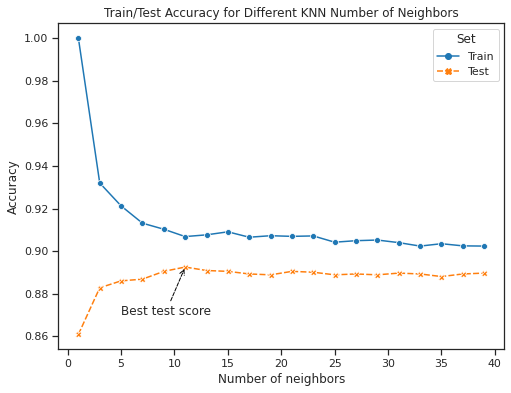

In [ ]:
accuracy_scores_df = pd.DataFrame.from_dict(accuracy_scores_knn).reset_index()
accuracy_scores_df.columns = ["Number of neighbors", "Train", "Test"]
accuracy_scores_df_long = pd.melt(accuracy_scores_df, id_vars = ["Number of neighbors"])
accuracy_scores_df_long.columns = ["Number of neighbors", "Set", "Accuracy"]

fig, ax = plt.subplots(figsize=(8, 6))
g = sns.lineplot(x = "Number of neighbors", y = "Accuracy", data = accuracy_scores_df_long,
             hue = "Set", style = "Set", markers = True, ax = ax)
g.set_title("Train/Test Accuracy for Different KNN Number of Neighbors")
best_score = accuracy_scores_df_long.loc[accuracy_scores_df_long["Set"] == "Test",].sort_values("Accuracy", ascending = False).iloc[0, [0,2]]
ax.annotate("Best test score", xy = (best_score["Number of neighbors"], best_score["Accuracy"]),
            xytext = (5, 0.87), arrowprops={"arrowstyle":"->", "color":"black", "ls":"dashed"})
plt.show()

In [ ]:
def model_pipe_hyperSearch(model, scaler, grid_params, randomsearch = False):
  num_pipeline = Pipeline([
          ('scaler', scaler),
      ])
  cat_pipeline = Pipeline([
          ('hot', OneHotEncoder(sparse = False, handle_unknown="ignore")),
      ])

  preprocessor = ColumnTransformer([
          ("num", num_pipeline, num_attribs),
          ("cat", cat_pipeline, cat_attribs),
      ])
  classifierpipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', model)])
  
  if not randomsearch:
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    search = GridSearchCV(estimator = classifierpipe, param_grid = grid_params, cv = cv, n_jobs = -1, verbose = 3, scoring = "f1")
    result = search.fit(X_train, y_train)
    best_param_score = {"Params":result.best_params_, "Score":result.best_score_}
    return best_param_score
  else:
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    search = RandomizedSearchCV(estimator = classifierpipe, param_distributions = grid_params, cv = cv, 
                                n_jobs = -1, verbose = 3, scoring = "f1", n_iter = 350)
    result = search.fit(X_train, y_train)
    best_param_score = {"Params":result.best_params_, "Score":result.best_score_}
    return best_param_score

In [ ]:
# svc_params = {"clf__C": [0.001, 0.01, 0.1, 1, 100], "clf__gamma":[0.001, 0.01, 0.1, 1, 5]}
# knn_params = {"clf__n_neighbors":np.arange(1,101,2)}
# rnd_params = {'clf__n_estimators': np.arange(100,1500,100), 'clf__criterion': ['gini', 'entropy'],
#               'clf__max_depth':np.arange(2,20), 'clf__max_features':['auto', 'sqrt', 'log2'], 'clf__min_samples_leaf':np.arange(2,20),
#               'clf__min_samples_split':np.arange(2,20)}

# model_pipe_hyperSearch(model = knn_clf, scaler = StandardScaler(), grid_params = knn_params)
# output: {'Params': {'clf__n_neighbors': 3}, 'Score': 0.494} -> Keep this commented out when running

# model_pipe_hyperSearch(model = knn_clf, scaler = FunctionTransformer(np.log1p), grid_params = knn_params)
# output: {'Params': {'clf__n_neighbors': 29}, 'Score': 0.629} -> Keep this commented out when running

# model_pipe_hyperSearch(model = svc_clf, scaler = StandardScaler(), grid_params = svc_params)
# output: 'Params': {'clf__C': 100, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}, 'Score': 0.614} -> Keep this commented out when running

# model_pipe_hyperSearch(model = svc_clf, scaler = FunctionTransformer(np.log1p), grid_params = svc_params)
# output: {'Params': {'clf__C': 1, 'clf__gamma': 0.001}, 'Score': 0.656} -> Keep this commented out when running

# model_pipe_hyperSearch(model = rnd_clf, scaler = FunctionTransformer(np.log1p), grid_params = rnd_params, randomsearch = True) #Takes way too long with gridsearch so tried randomized search instead.
# output: {'Params': {'clf__n_estimators': 800, 'clf__min_samples_split': 14, 'clf__min_samples_leaf': 3, 'clf__max_features': 'sqrt', 'clf__max_depth': 18, 'clf__criterion': 'entropy'}, 'Score': 0.628} -> Keep this commented out when running

# model_pipe_hyperSearch(model = rnd_clf, scaler = StandardScaler(), grid_params = rnd_params, randomsearch = True) #Takes way too long with gridsearch so tried randomized search instead.
# output: {'Params': {'clf__n_estimators': 1200, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 2, 'clf__max_features': 'auto', 'clf__max_depth': 18, 'clf__criterion': 'entropy'}, 'Score': 0.630} -> Keep this commented out when running


In [ ]:
# Tuned parameters for standard-scaled data

svc_clf_base_tuned_std = SVC(random_state = 42, C = 100, gamma = 0.01, kernel = 'rbf')
knn_clf_base_tuned_std = KNeighborsClassifier(n_neighbors = 3)
rnd_clf_base_tuned_std = RandomForestClassifier(n_estimators = 1200, min_samples_split = 11,
                                            min_samples_leaf = 2, max_features = 'auto',
                                            max_depth = 18, criterion = 'entropy',
                                            random_state = 42)

baseline_scores_std_list_tuned = [model_pipeline(clf, StandardScaler(), crossval = True) for clf in (svc_clf_base_tuned_std, knn_clf_base_tuned_std, rnd_clf_base_tuned_std)]

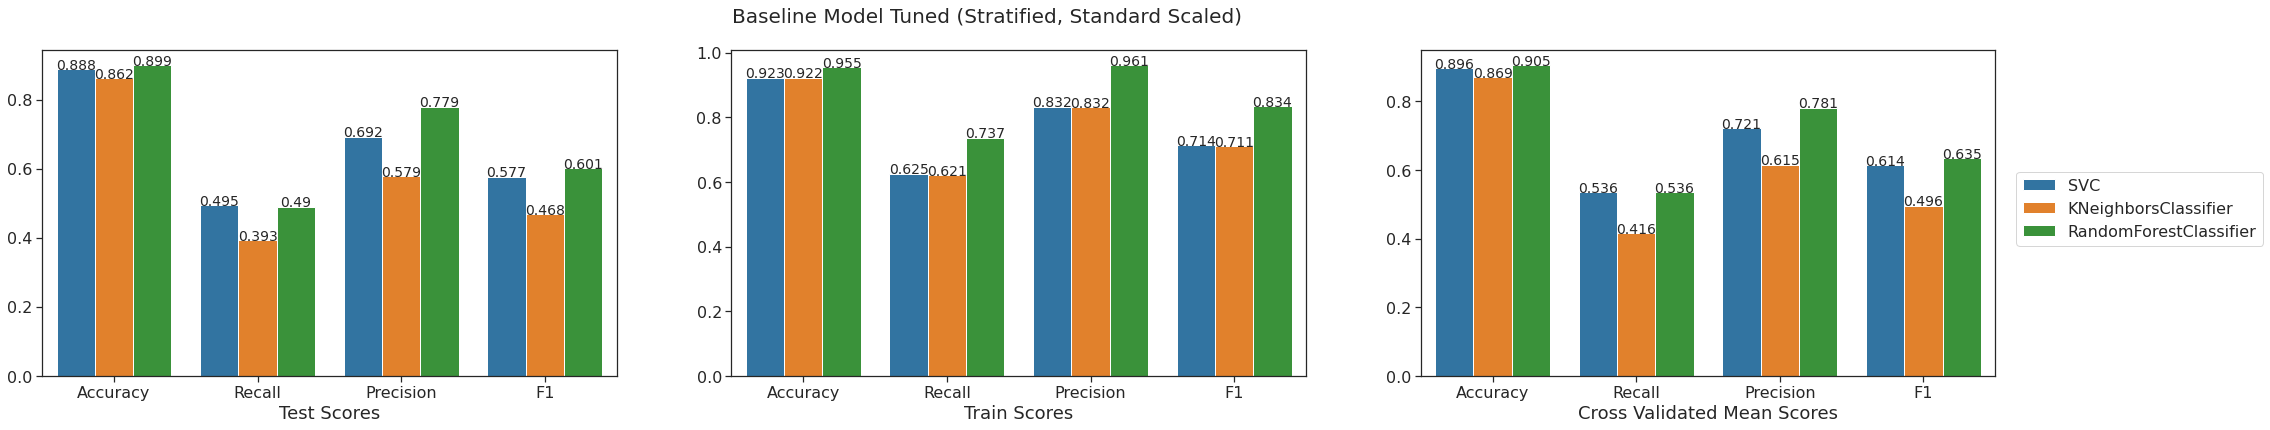

In [ ]:
plot_scores(baseline_scores_std_list_tuned, "Baseline Model Tuned (Stratified, Standard Scaled)", add_to_final_scores=True)

In [ ]:
# Tuned parameters for log-transformed data

svc_clf_base_tuned_log = SVC(random_state = 42, C = 1, gamma = 0.001, kernel = 'rbf')
knn_clf_base_tuned_log = KNeighborsClassifier(n_neighbors = 29)
rnd_clf_base_tuned_log = RandomForestClassifier(n_estimators = 800, min_samples_split = 14,
                                            min_samples_leaf = 3, max_features = 'sqrt',
                                            max_depth = 18, criterion = 'entropy',
                                            random_state = 42)

baseline_scores_log_list_tuned = [model_pipeline(clf, FunctionTransformer(np.log1p), crossval = True) for clf in (svc_clf_base_tuned_log, knn_clf_base_tuned_log, rnd_clf_base_tuned_log)]

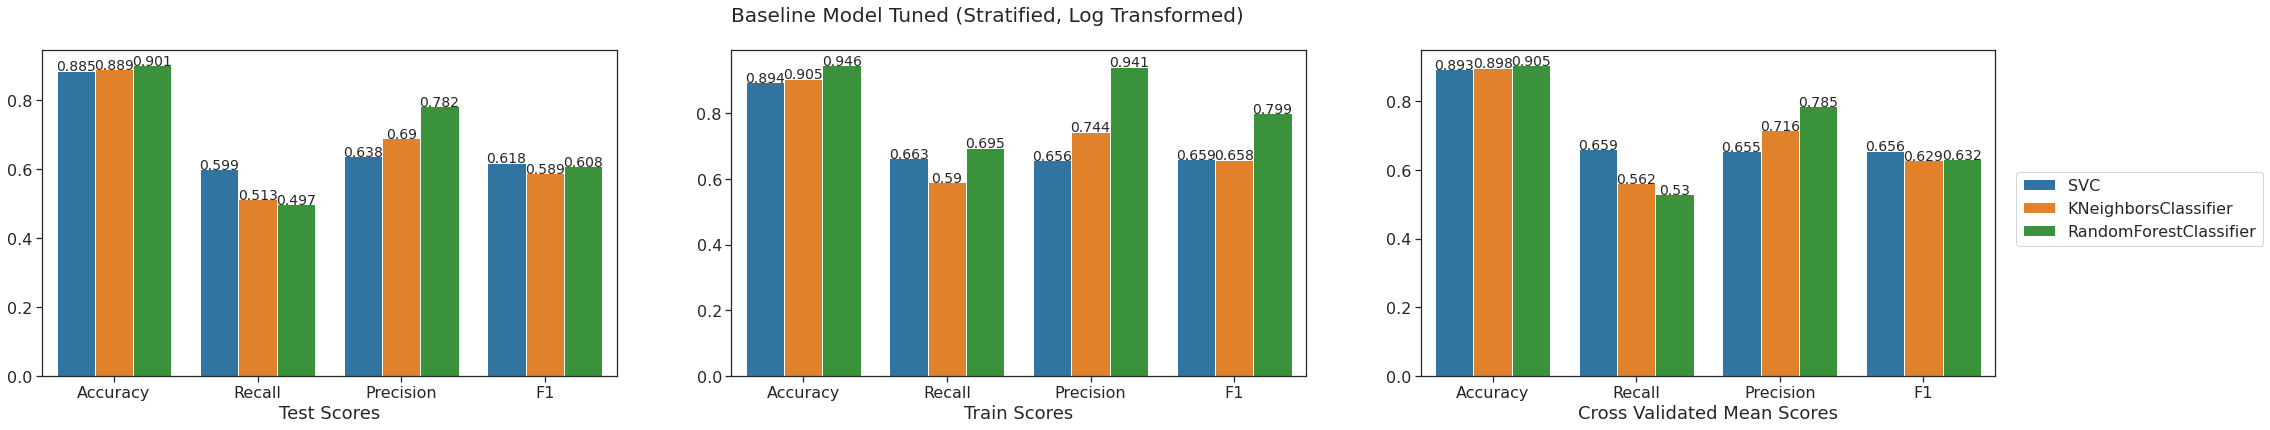

In [ ]:
plot_scores(baseline_scores_log_list_tuned, "Baseline Model Tuned (Stratified, Log Transformed)", add_to_final_scores=True)

In [ ]:
pd.options.mode.chained_assignment = None
scores_so_far = pd.concat(list(merged_scores.values()))
trial_std_base_comp = scores_so_far.copy()
trial_std_base_comp["Scale"] = np.where(trial_std_base_comp["Type"].str.contains("Standard"), "Standard", "Log")
trial_std_base_comp["Tune Type"]= np.where(trial_std_base_comp["Type"].str.contains("Tuned"), "Tuned", "Untuned")
trial_std_base_comp['Classification Model'].replace('KNeighborsClassifier','KNN', inplace=True)
trial_std_base_comp['Classification Model'].replace('RandomForestClassifier','Random Forest', inplace=True)

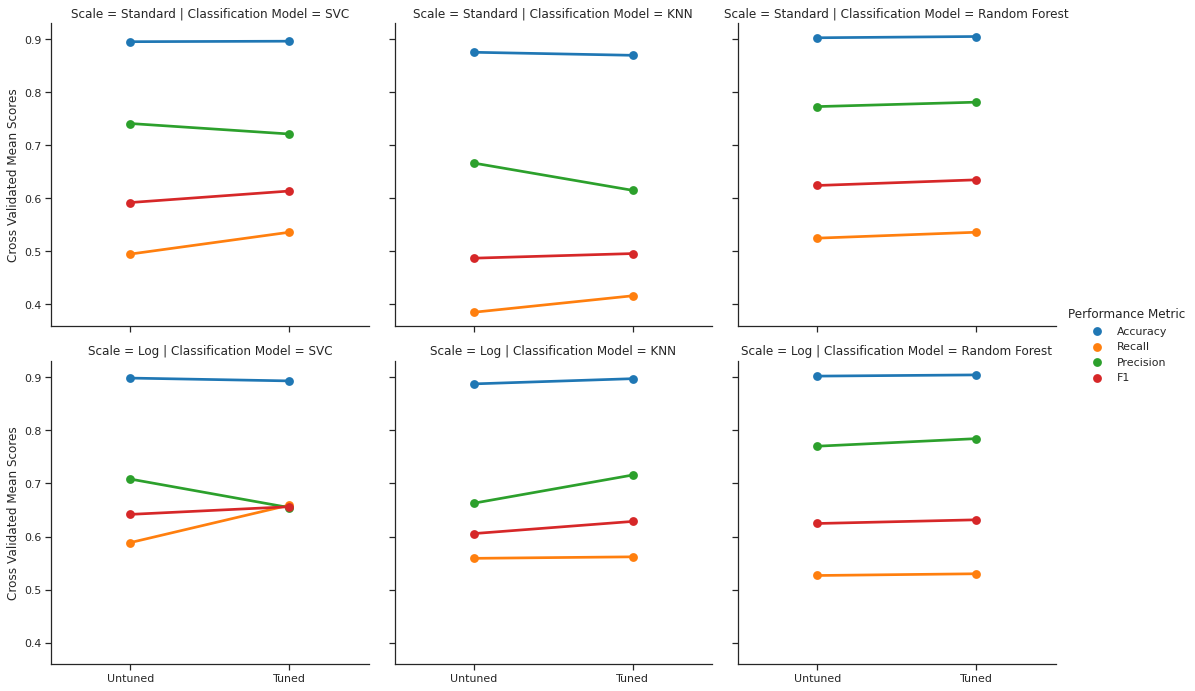

In [ ]:
g = sns.catplot(x = "Tune Type", y = "Cross Validated Mean Scores", hue = "Performance Metric", 
            col = "Classification Model", row = "Scale", data = trial_std_base_comp, kind = "point")
g.set(xlabel = None)
plt.show()

The above point plots confirm that the tuned models had better relevant performance metrics (F1 and Recall) than their untuned counterparts. Precision might have decreased slightly in some cases, but the decrease was minimal and precision isn't the performance metric we're interested in anyway. Accordingly, the tuned models (both standard scaled and log-scaled) will be kept in the list of final models and the untuned ones will be discarded.

In [ ]:
del merged_scores["Baseline Model (Stratified, Standard Scaler)"]
del merged_scores["Baseline Model (Stratified, Log Transformed)"]

##3.2 - Baseline model (SMOTE Oversampling)

Let's try another data sampling technique. Instead of dividing our train/test splits to accurately represent the class imbalance, let's try to purposefully oversample our train set using SMOTE, train our models on the oversampled train set, and predict on our test test. 

In [ ]:
#SMOTE Oversampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as PipeImb

X_train, X_test, y_train, y_test = train_test_split(shopping_data.drop("Revenue", axis = 1), shopping_data["Revenue"], random_state=42)

def smt_model_pipeline(model, scaler, crossval = False, confusion = False):
  num_pipeline = Pipeline([
          ('scaler', scaler),
      ])
  cat_pipeline = Pipeline([
          ('hot', OneHotEncoder(sparse = False, handle_unknown = "ignore")),
      ])

  preprocessor = ColumnTransformer([
          ("num", num_pipeline, num_attribs),
          ("cat", cat_pipeline, cat_attribs),
      ])
  
  smote = SMOTE(random_state = 42)
  X_train_prep = preprocessor.fit_transform(X_train)
  X_test_prep = preprocessor.transform(X_test)
  X_train_smt, y_train_smt = smote.fit_resample(X_train_prep, y_train)
  classifierpipe = Pipeline(steps=[('classifier', model)])
  classifierpipe.fit(X_train_smt, y_train_smt)
  y_predict_test = classifierpipe.predict(X_test_prep)
  y_predict_train = classifierpipe.predict(X_train_smt)
  c_matrix = confusion_matrix(y_test, y_predict_test)

  if crossval is True:
    split = KFold(n_splits = 10)
    accuracy_scores = []
    recall_scores = []
    precision_scores = []
    f1_scores = []
    for train_index, test_index in split.split(X_train, y_train):
      X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
      y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
      X_train_fold_prep = preprocessor.fit_transform(X_train_fold)
      X_test_fold_prep = preprocessor.transform(X_test_fold)
      X_train_smt_fold, y_train_smt_fold = smote.fit_resample(X_train_fold_prep, y_train_fold)
      model.fit(X_train_smt_fold, y_train_smt_fold)
      y_pred_fold = model.predict(X_test_fold_prep)
      accuracy_scores.append(accuracy_score(y_test_fold, y_pred_fold))
      recall_scores.append(recall_score(y_test_fold, y_pred_fold))
      precision_scores.append(precision_score(y_test_fold, y_pred_fold))
      f1_scores.append(f1_score(y_test_fold, y_pred_fold))

    results_dict_cross = {"Classification Model":model.__class__.__name__, 
                  "Test Scores":{"Accuracy":accuracy_score(y_test, y_predict_test), "Recall":recall_score(y_test, y_predict_test), 
                          "Precision":precision_score(y_test, y_predict_test), "F1":f1_score(y_test, y_predict_test)}, 
                  "Train Scores":{"Accuracy":accuracy_score(y_train_smt, y_predict_train), "Recall":recall_score(y_train_smt, y_predict_train), 
                           "Precision":precision_score(y_train_smt, y_predict_train), "F1":f1_score(y_train_smt, y_predict_train)},
                  "Cross Validated Mean Scores": {"Accuracy":np.mean(accuracy_scores),
                                       "Recall": np.mean(recall_scores),
                                       "Precision": np.mean(precision_scores),
                                       "F1": np.mean(f1_scores)},
                  "Cross Validated SD Scores": {"Accuracy":np.std(accuracy_scores),
                                          "Recall": np.std(recall_scores),
                                          "Precision": np.std(precision_scores),
                                          "F1": np.std(f1_scores)}}
    if confusion is False:
      return results_dict_cross
    else:               
      return results_dict_cross, c_matrix
  else:
    results_dict = {"Classification Model":model.__class__.__name__,
                  "Test Scores":{"Accuracy":accuracy_score(y_test, y_predict_test), "Recall":recall_score(y_test, y_predict_test), 
                          "Precision":precision_score(y_test, y_predict_test), "F1":f1_score(y_test, y_predict_test)},
                  "Train Scores":{"Accuracy":accuracy_score(y_train_smt, y_predict_train), "Recall":recall_score(y_train_smt, y_predict_train), 
                           "Precision":precision_score(y_train_smt, y_predict_train), "F1":f1_score(y_train_smt, y_predict_train)}}
    if confusion is False:
      return results_dict
    else:
      return results_dict, c_matrix


###3.2.1 - Using Standard Scaler

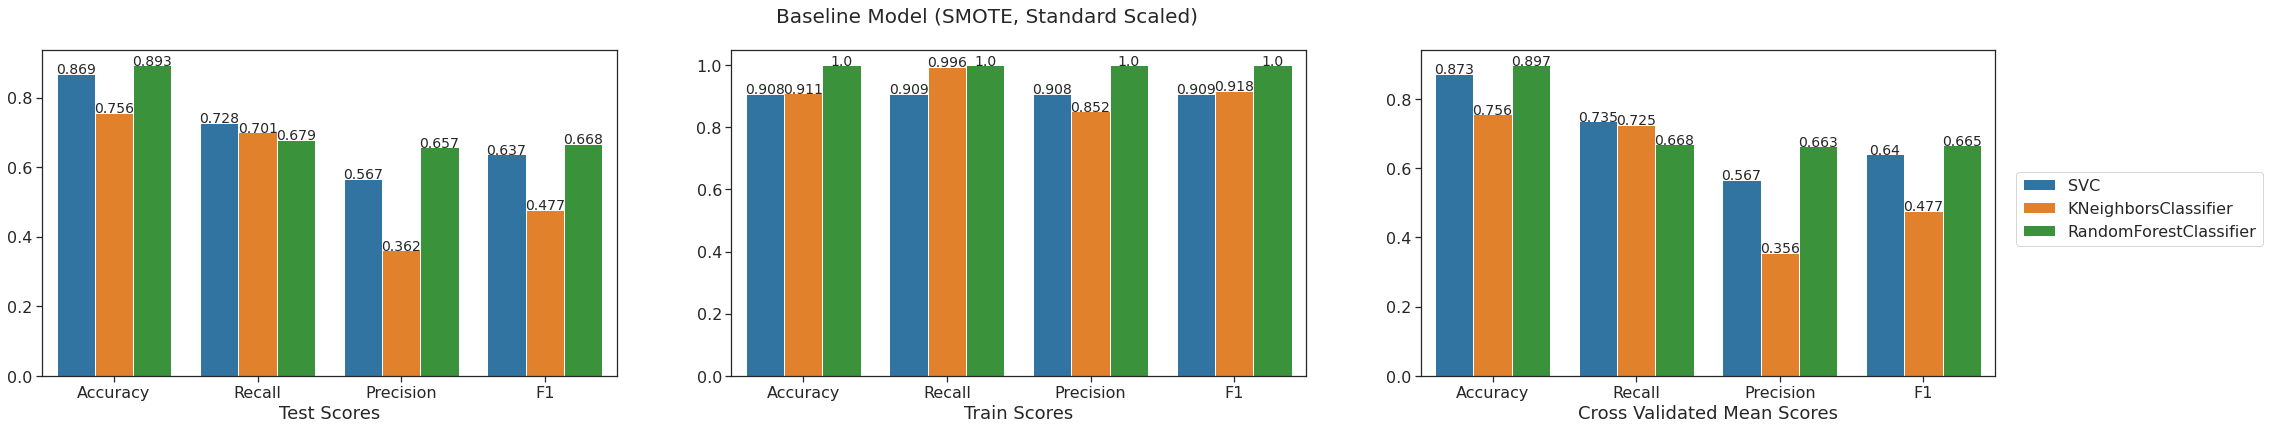

In [ ]:
smt_scores_list_base = [smt_model_pipeline(clf, StandardScaler(), crossval = True) for clf in (svc_clf, knn_clf, rnd_clf)]
plot_scores(smt_scores_list_base, "Baseline Model (SMOTE, Standard Scaled)", add_to_final_scores=True)

###3.2.2 - Using Log Transformation

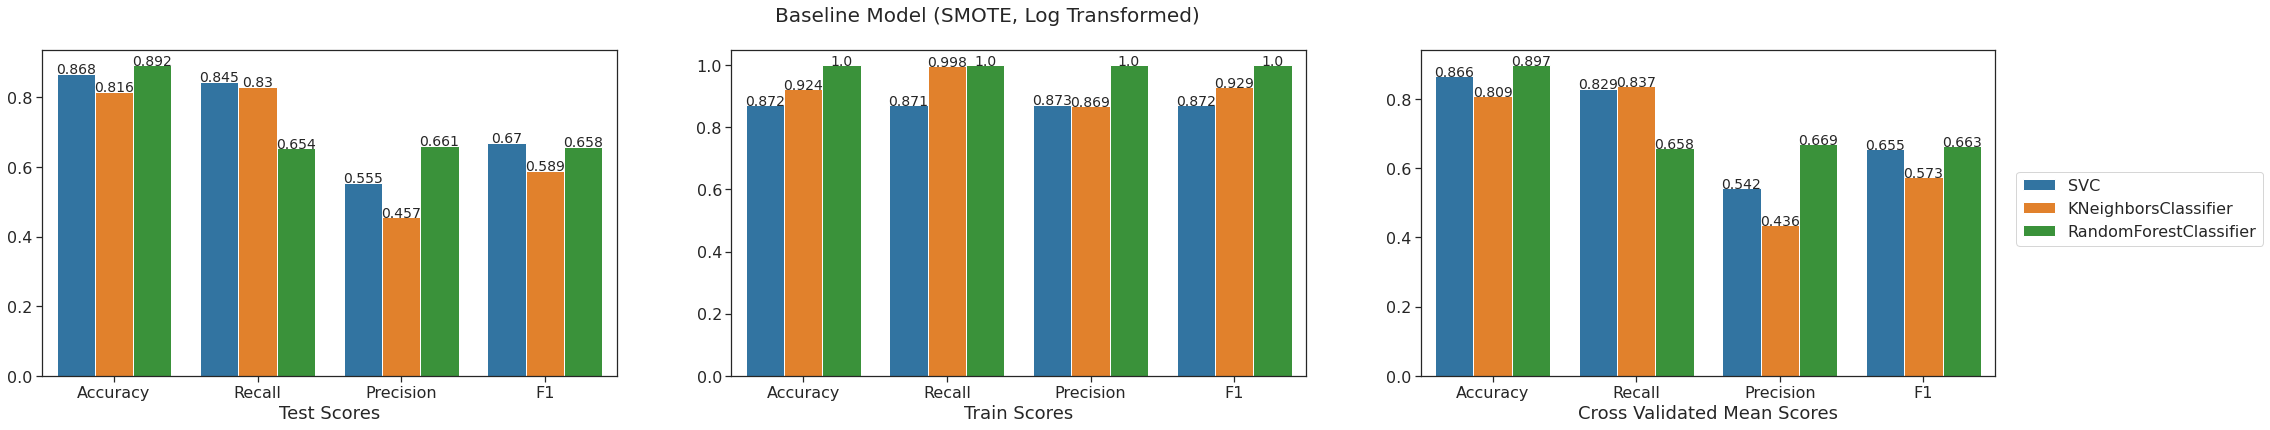

In [ ]:
smt_scores_list_base_log = [smt_model_pipeline(clf, FunctionTransformer(np.log1p), crossval = True) for clf in (svc_clf, knn_clf, rnd_clf)]
plot_scores(smt_scores_list_base_log, "Baseline Model (SMOTE, Log Transformed)", add_to_final_scores=True)

###3.2.3 - Hyperparameter Tuning

In [ ]:
def smt_pipe_hyperSearch(model, scaler, grid_params, randomsearch=False):
    num_pipeline = Pipeline([
        ('scaler', scaler),
    ])
    cat_pipeline = Pipeline([
        ('hot', OneHotEncoder(sparse=False, handle_unknown="ignore")),
    ])

    preprocessor = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

    pipe_smt = PipeImb([('smote', SMOTE(random_state=42)),
                        ('clf', model)
                        ])

    X_train_prep = preprocessor.fit_transform(X_train)

    if not randomsearch:
        search = GridSearchCV(estimator=pipe_smt, param_grid=grid_params, cv=KFold(n_splits=5), n_jobs=-1, verbose=3,
                              scoring="f1")
        result = search.fit(X_train_prep, y_train)
        best_param_score = {"Params": result.best_params_, "Score": result.best_score_}
        return best_param_score
    else:
        search = RandomizedSearchCV(estimator=pipe_smt, param_distributions=grid_params, cv=KFold(n_splits=5),
                                    n_jobs=-1, verbose=3, scoring="f1", n_iter=350)
        result = search.fit(X_train_prep, y_train)
        best_param_score = {"Params": result.best_params_, "Score": result.best_score_}
        return best_param_score

In [ ]:
# print(smt_pipe_hyperSearch(model = svc_clf, scaler = StandardScaler(), grid_params = svc_params))
# {'Params': {'clf__C': 1, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}, 'Score': 0.651} -> Keep this commented out when running

# print(smt_pipe_hyperSearch(model = svc_clf, scaler = FunctionTransformer(np.log1p), grid_params = svc_params))
# {'Params': {'clf__C': 1, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}, 'Score': 0.667} -> Keep this commented out when running

# print(smt_pipe_hyperSearch(model = knn_clf, scaler = StandardScaler(), grid_params = knn_params))
# output: {'Params': {'clf__n_neighbors': 85}, 'Score': 0.4895} -> Keep this commented out when running

# print(smt_pipe_hyperSearch(model = knn_clf, scaler = FunctionTransformer(np.log1p), grid_params = knn_params))
# output: {'Params': {'clf__n_neighbors': 91}, 'Score': 0.599} -> Keep this commented out when running

# print(smt_pipe_hyperSearch(model = rnd_clf, scaler = StandardScaler(), grid_params = rnd_params, randomsearch = True))
# print(smt_pipe_hyperSearch(model = rnd_clf, scaler = FunctionTransformer(np.log1p), grid_params = rnd_params, randomsearch = True))

In [ ]:
# Tuned parameters for standard-scaled data

svc_clf_base_tuned_std_smt = SVC(random_state = 42, C = 1, gamma = 0.01, kernel = 'rbf')
knn_clf_base_tuned_std_smt = KNeighborsClassifier(n_neighbors = 85)
rnd_clf_base_tuned_std_smt = RandomForestClassifier(n_estimators = 900, min_samples_split = 19,
                                            min_samples_leaf = 6, max_features = 'sqrt',
                                            max_depth = 17, criterion = 'gini',
                                            random_state = 42)

baseline_scores_std_list_smt_tuned = [smt_model_pipeline(clf, StandardScaler(), crossval = True) for clf in (svc_clf_base_tuned_std_smt, knn_clf_base_tuned_std_smt, rnd_clf_base_tuned_std_smt)]

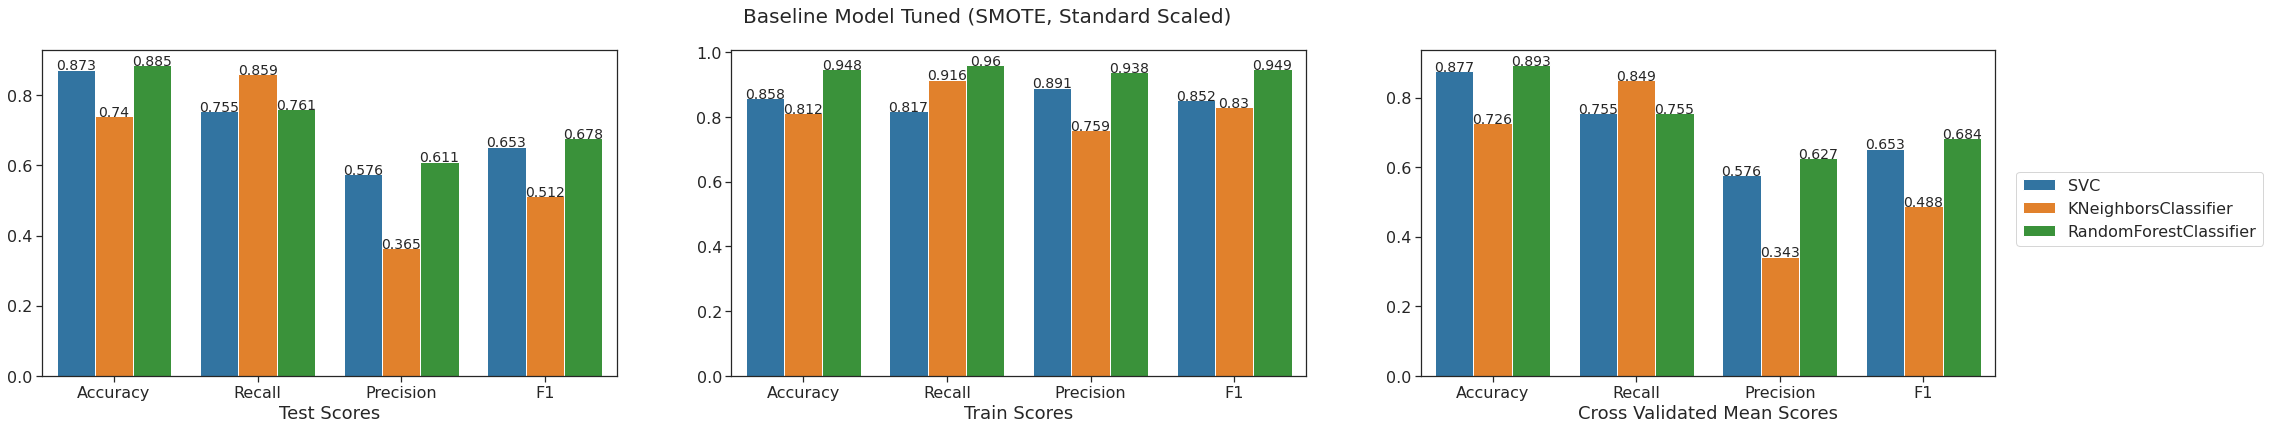

In [ ]:
plot_scores(baseline_scores_std_list_smt_tuned, "Baseline Model Tuned (SMOTE, Standard Scaled)", add_to_final_scores=True)

In [ ]:
# Tuned parameters for log-transformed data

svc_clf_base_tuned_log_smt = SVC(random_state = 42, C = 1, gamma = 0.001, kernel = 'rbf')
knn_clf_base_tuned_log_smt = KNeighborsClassifier(n_neighbors = 91)
rnd_clf_base_tuned_log_smt = RandomForestClassifier(n_estimators = 400, min_samples_split = 16,
                                            min_samples_leaf = 9, max_features = 'sqrt',
                                            max_depth = 17, criterion = 'entropy',
                                            random_state = 42)

baseline_scores_std_list_log_tuned = [smt_model_pipeline(clf, FunctionTransformer(np.log1p), crossval = True) for clf in (svc_clf_base_tuned_log_smt, knn_clf_base_tuned_log_smt, rnd_clf_base_tuned_log_smt)]

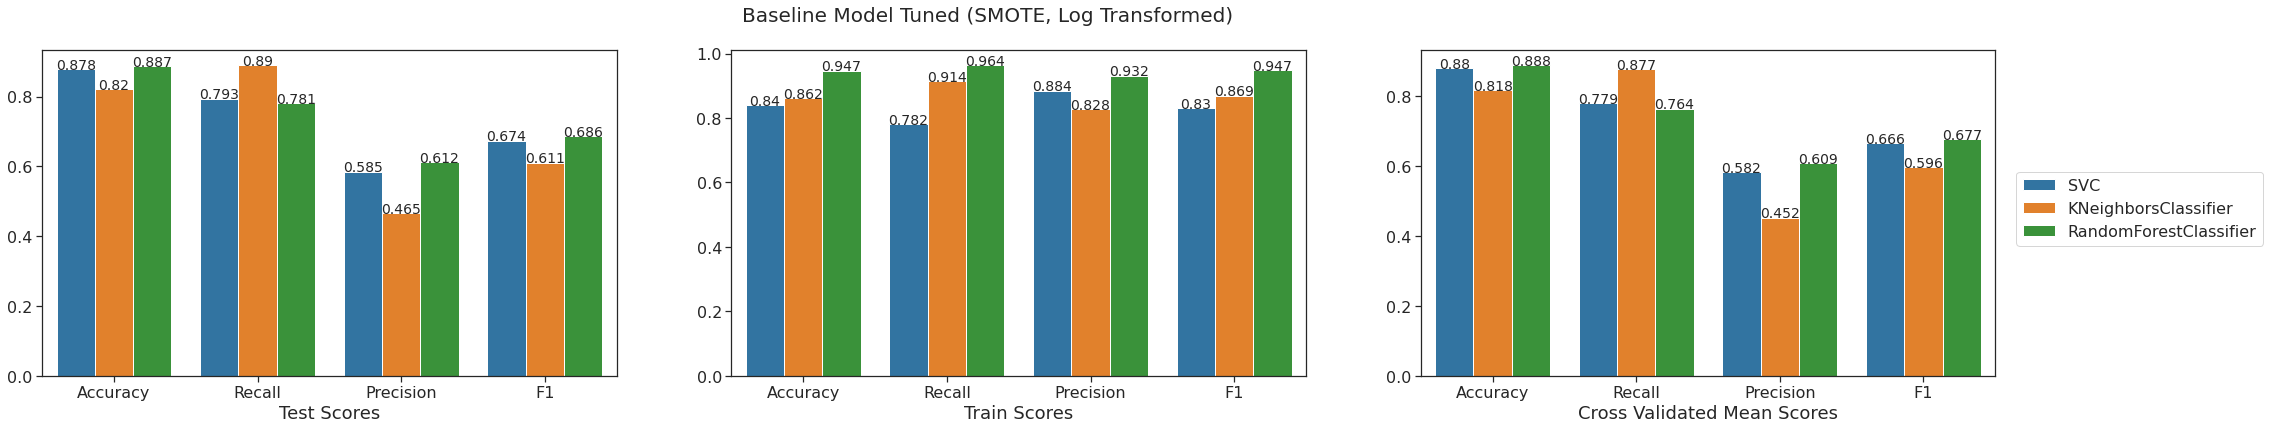

In [ ]:
plot_scores(baseline_scores_std_list_log_tuned, "Baseline Model Tuned (SMOTE, Log Transformed)", add_to_final_scores=True)

In [ ]:
merged_scores
smote_scores_base = {k:v for k,v in merged_scores.items() if "SMOTE" in k}
scores_so_far_2 = pd.concat(list(smote_scores_base.values()))
smote_base_comp = scores_so_far_2.copy()
smote_base_comp["Scale Type"] = np.where(smote_base_comp["Type"].str.contains("Standard"), "Standard", "Log")
smote_base_comp["Tune Type"]= np.where(smote_base_comp["Type"].str.contains("Tuned"), "Tuned", "Untuned")
smote_base_comp['Classification Model'].replace('KNeighborsClassifier','KNN', inplace=True)
smote_base_comp['Classification Model'].replace('RandomForestClassifier','Random Forest', inplace=True)

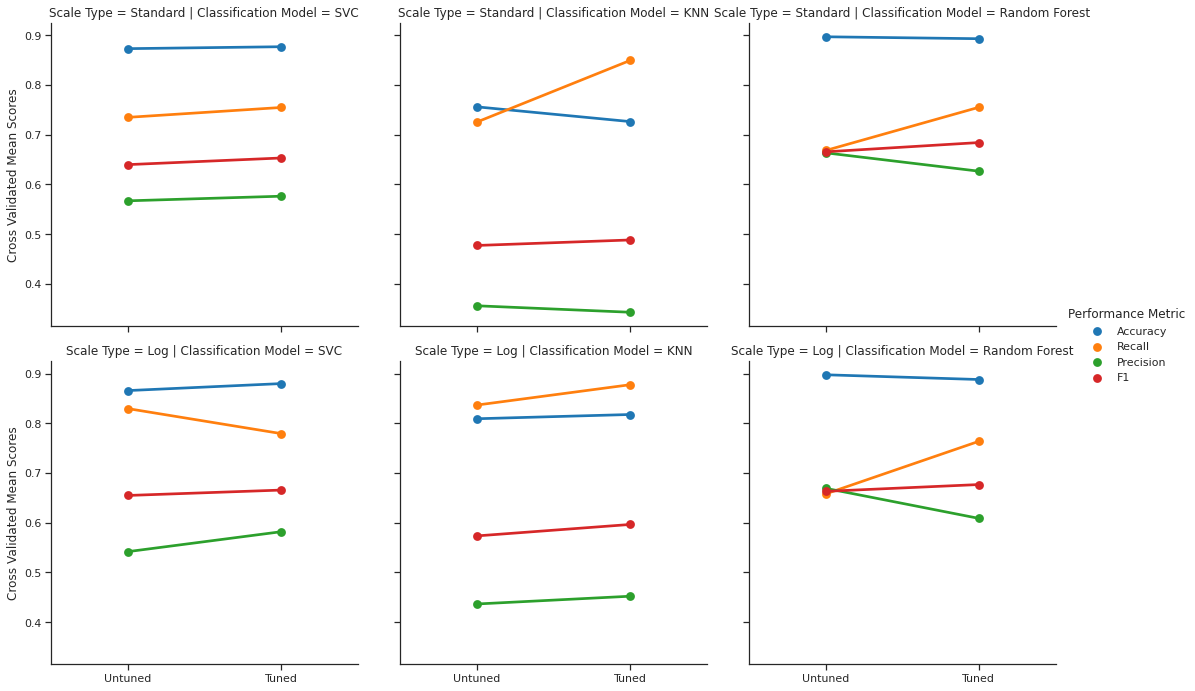

In [ ]:
g = sns.catplot(x = "Tune Type", y = "Cross Validated Mean Scores", hue = "Performance Metric", 
            col = "Classification Model", row = "Scale Type", data = smote_base_comp, kind = "point")
g.set(xlabel = None)
plt.show()


Distinction isn't as clear as in the stratified case (I don't like how recall is sharply dropping in the log SVC case). Going to leave both in for final results comparison.

Another thing to note here is that KNN and SVC were prone to underfit in the stratified sampling with recall/precision/f1 barely scraping 70% in a lot of train test cases. However, SMOTE solved the problem of undefitting for all models and highly improved test/cross-validated mean scores compared when compared to the stratified case. 

##3.3 - Feature Engineered Model

### 3.3.1 - From Constructed Total Visits Columns

Small note for this section: I've directly added the models with tuned hyperparameters using grid/random search instead of plotting the defaults first like above. This is just to avoid cluttering the notebook with figures. 

In [ ]:
feature_df = shopping_data.copy()
feature_df.loc[feature_df["ProductRelated_Duration"] > 20000, "ProductRelated_Duration"] = 20000
# Add total visits columns and drop inividual types of visits
feature_df["Total Visits"] = feature_df["Administrative"] + feature_df["Informational"] + feature_df["ProductRelated"]  
feature_df.drop(["Administrative", "Informational", "ProductRelated"], axis = 1, inplace = True)  

#Dropping lowest importance categorical columns as obtained by random forrest classifier
feature_df.drop(["Region","Browser","OperatingSystems"], axis = 1, inplace = True) 

num_attribs = feature_df.select_dtypes(include=np.number).columns.tolist()
num_attribs.remove("Revenue")
cat_attribs = feature_df.select_dtypes(include=['category']).columns.tolist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature_df.drop("Revenue", axis = 1), feature_df["Revenue"], random_state=42)

In [ ]:
# Tuned parameters for standard data

svc_clf_fe_tuned_std_smt = SVC(random_state = 42, C = 1, gamma = 0.01, kernel = 'rbf')
knn_clf_fe_tuned_std_smt = KNeighborsClassifier(n_neighbors = 93)
rnd_clf_fe_tuned_std_smt = RandomForestClassifier(n_estimators = 400, min_samples_split = 13,
                                            min_samples_leaf = 3, max_features = 'auto',
                                            max_depth = 19, criterion = 'gini',
                                            random_state = 42)

features_scores_std_list_tuned = [smt_model_pipeline(clf, StandardScaler(), crossval = True) for clf in (svc_clf_fe_tuned_std_smt, knn_clf_fe_tuned_std_smt, rnd_clf_fe_tuned_std_smt)]

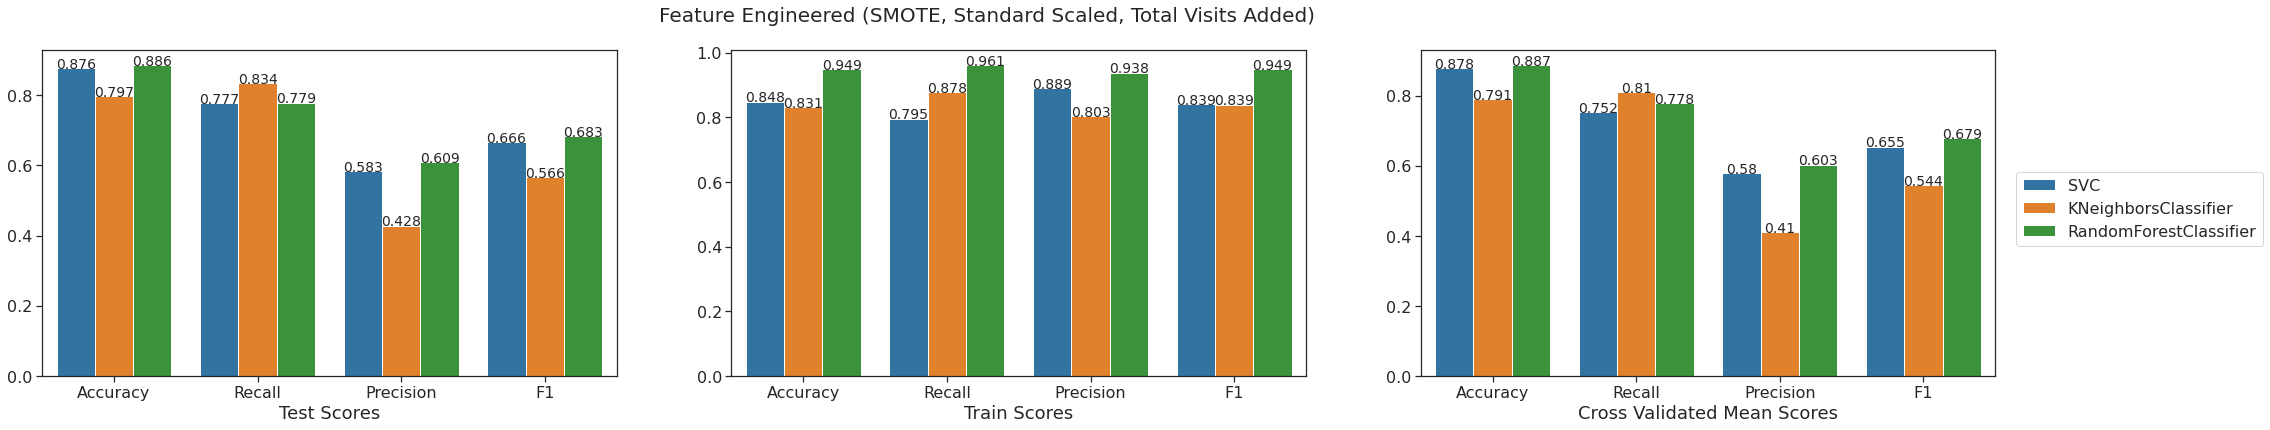

In [ ]:
plot_scores(features_scores_std_list_tuned, "Feature Engineered (SMOTE, Standard Scaled, Total Visits Added)", add_to_final_scores=True)

In [ ]:
# Tuned parameters for log-transformed data

svc_clf_fe_tuned_log_smt = SVC(random_state = 42) # Default parameters kept since gridsearch marginally increased f1 score but decreased recall
knn_clf_fe_tuned_log_smt = KNeighborsClassifier(n_neighbors = 93)
rnd_clf_fe_tuned_log_smt = RandomForestClassifier(n_estimators = 400, min_samples_split = 14,
                                            min_samples_leaf = 2, max_features = 'auto',
                                            max_depth = 19, criterion = 'gini',
                                            random_state = 42)

features_scores_log_list_tuned = [smt_model_pipeline(clf, FunctionTransformer(np.log1p), crossval = True) for clf in (svc_clf_fe_tuned_log_smt, knn_clf_fe_tuned_log_smt, rnd_clf_fe_tuned_log_smt)]

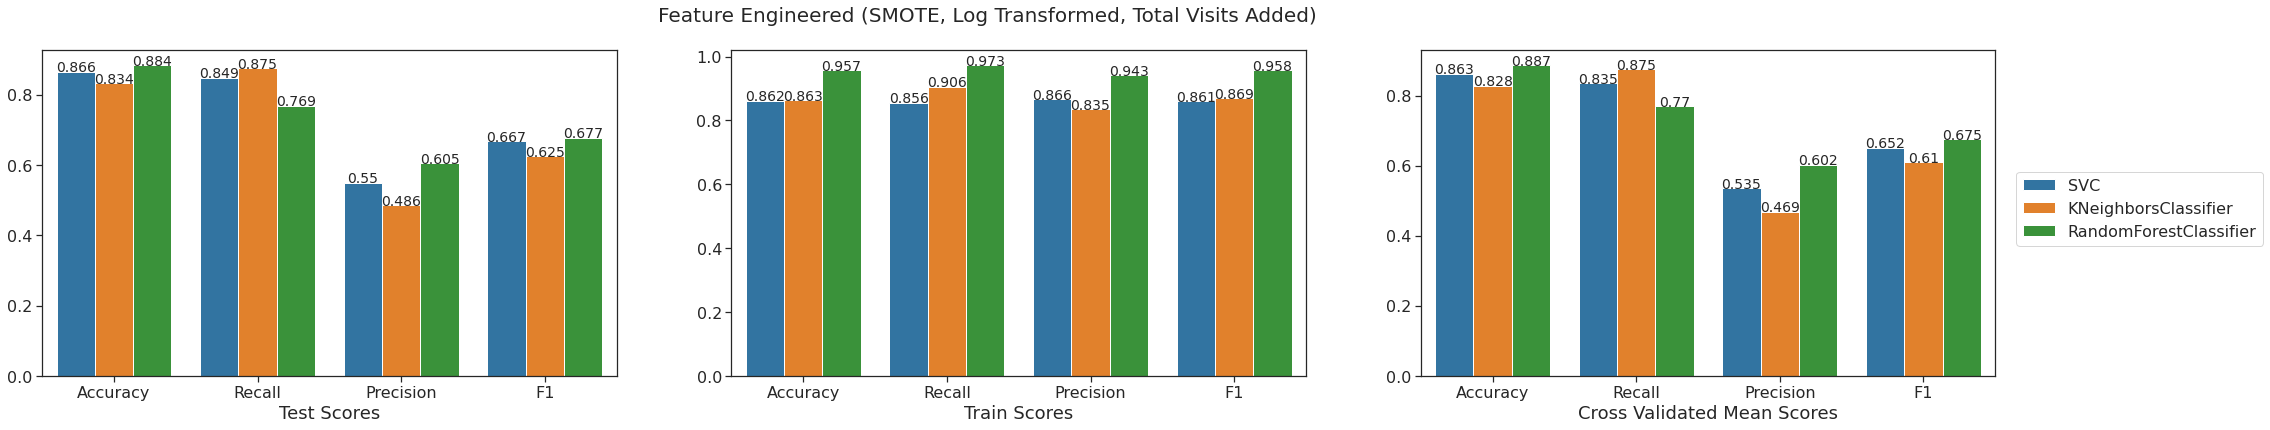

In [ ]:
plot_scores(features_scores_log_list_tuned, "Feature Engineered (SMOTE, Log Transformed, Total Visits Added)", add_to_final_scores=True)

### 3.3.2 - Months to Quarters Column

In [ ]:
months_mapping = {"Jan":"Q1", "Feb":"Q1", "Mar":"Q1","Apr":"Q2", "May":"Q2",
"June":"Q2", "Jul":"Q3", "Aug":"Q3", "Sep":"Q3", "Oct":"Q4", "Nov":"Q4", "Dec":"Q4"}
feature_df["Month"] = feature_df["Month"].replace(months_mapping).astype('category')

num_attribs = feature_df.select_dtypes(include=np.number).columns.tolist()
num_attribs.remove("Revenue")
cat_attribs = feature_df.select_dtypes(include=['category']).columns.tolist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature_df.drop("Revenue", axis = 1), feature_df["Revenue"], random_state=42)

In [ ]:
# Tuned parameters for standard data

svc_clf_fe_mo_tuned_std_smt = SVC(random_state = 42, C = 100, gamma = 0.001, kernel = 'rbf')
knn_clf_fe_mo_tuned_std_smt = KNeighborsClassifier(n_neighbors = 91)
rnd_clf_fe_mo_tuned_std_smt = RandomForestClassifier(n_estimators = 800, min_samples_split = 7,
                                            min_samples_leaf = 4, max_features = 'sqrt',
                                            max_depth = 16, criterion = 'gini',
                                            random_state = 42)

features_mo_scores_std_list_tuned = [smt_model_pipeline(clf, StandardScaler(), crossval = True) for clf in (svc_clf_fe_mo_tuned_std_smt, knn_clf_fe_mo_tuned_std_smt, rnd_clf_fe_mo_tuned_std_smt)]

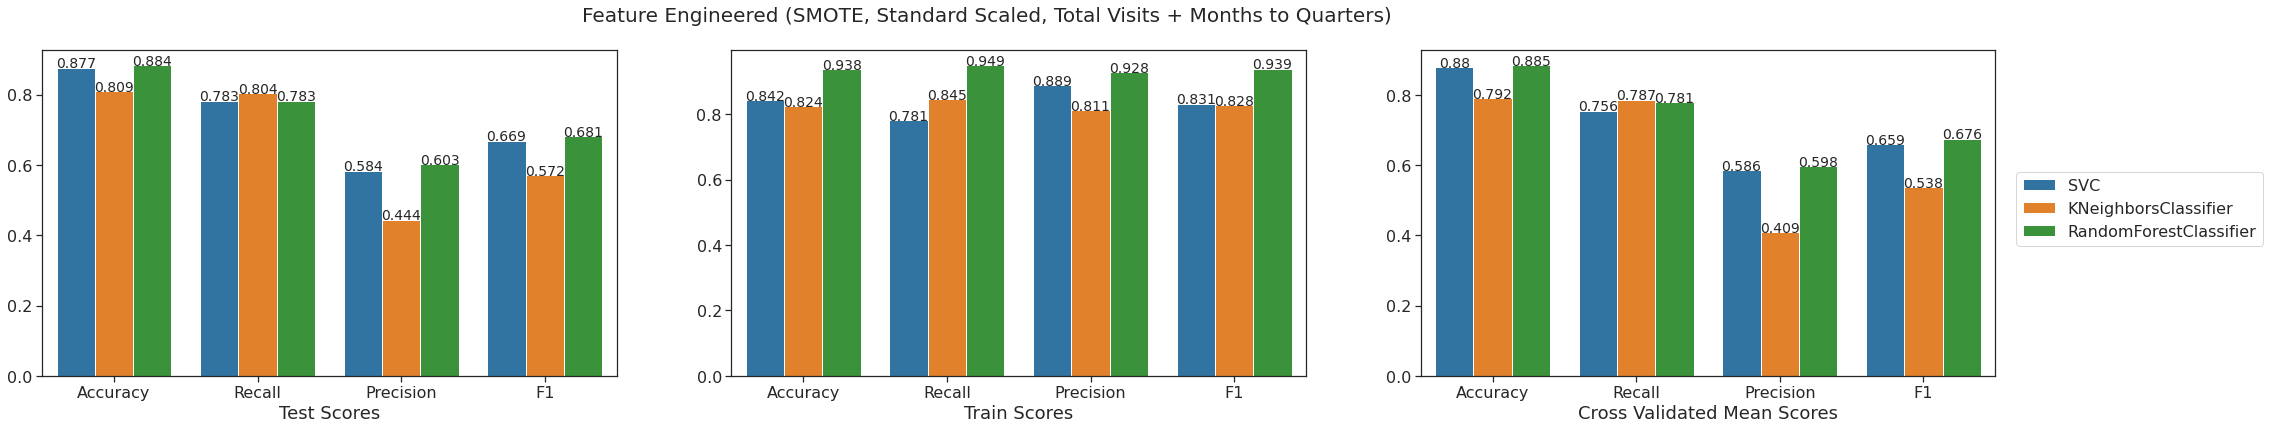

In [ ]:
plot_scores(features_mo_scores_std_list_tuned, "Feature Engineered (SMOTE, Standard Scaled, Total Visits + Months to Quarters)", add_to_final_scores=True)

In [ ]:
# Tuned parameters for log transformed data

svc_clf_fe_mo_tuned_log_smt = SVC(random_state = 42, C = 1, gamma = 0.01, kernel = 'rbf')
knn_clf_fe_mo_tuned_log_smt = KNeighborsClassifier(n_neighbors = 95)
rnd_clf_fe_mo_tuned_log_smt = RandomForestClassifier(n_estimators = 1100, min_samples_split = 13,
                                            min_samples_leaf = 2, max_features = 'sqrt',
                                            max_depth = 17, criterion = 'gini',
                                            random_state = 42)

features_mo_scores_log_list_tuned = [smt_model_pipeline(clf, FunctionTransformer(np.log1p), crossval = True) for clf in (svc_clf_fe_mo_tuned_log_smt, knn_clf_fe_mo_tuned_log_smt, rnd_clf_fe_mo_tuned_log_smt)]

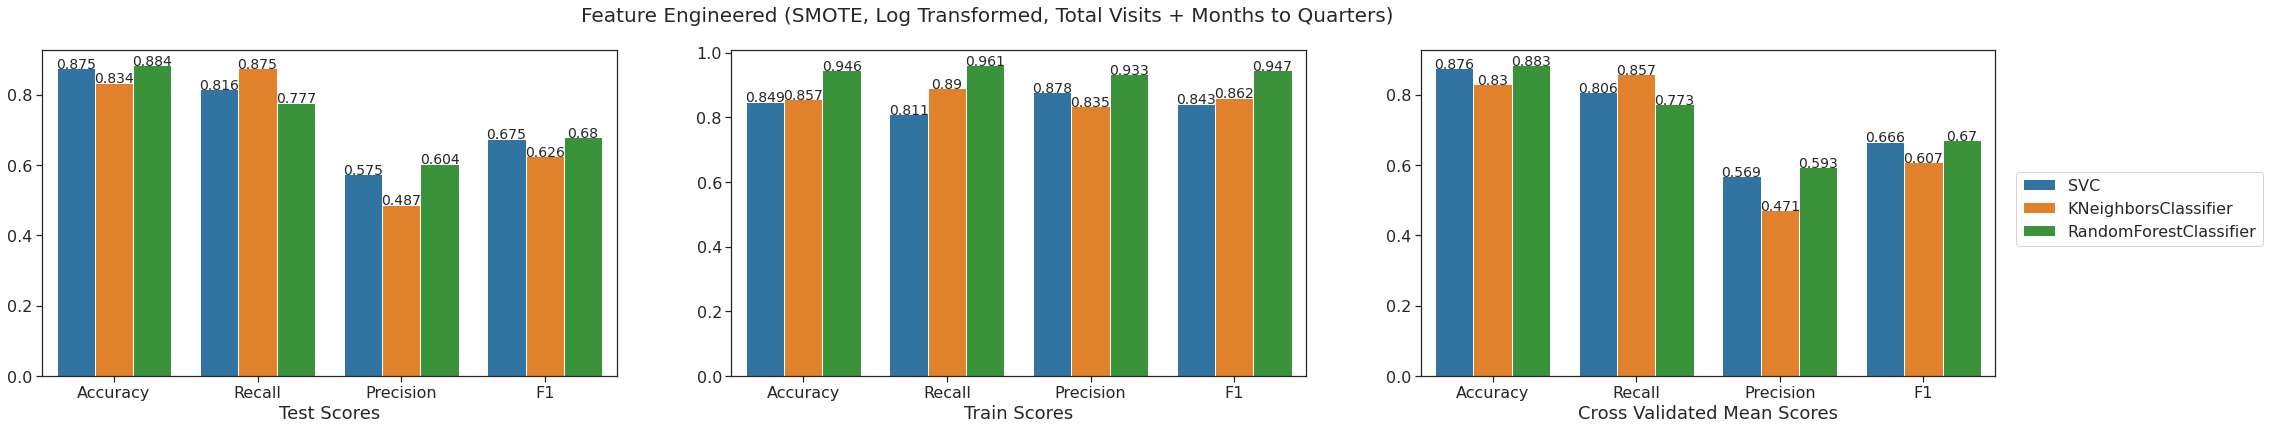

In [ ]:
plot_scores(features_mo_scores_log_list_tuned, "Feature Engineered (SMOTE, Log Transformed, Total Visits + Months to Quarters)", add_to_final_scores=True)

#4) Results Comparison

In [ ]:
def plot_full_results(final_scores_dict):
  final_df = pd.concat(list(final_scores_dict.values())).reset_index().drop("index", axis = 1)
  final_df.drop("Cross Validated SD Scores", axis = 1, inplace = True)
  k = pd.melt(final_df, id_vars = ["Performance Metric", "Classification Model", "Type"])
  final_results_df = k.pivot_table(index = ['Classification Model','Type'], columns = ["Performance Metric", "variable"], values = "value")

  g = sns.catplot(x = "Type", y = "Cross Validated Mean Scores", hue = "Performance Metric", data = final_df, kind = "point", 
                  col = "Classification Model", height = 6, aspect = 1)
  g.set(xlabel = None)
  for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
  g.fig.subplots_adjust(wspace=.25)
  plt.show()

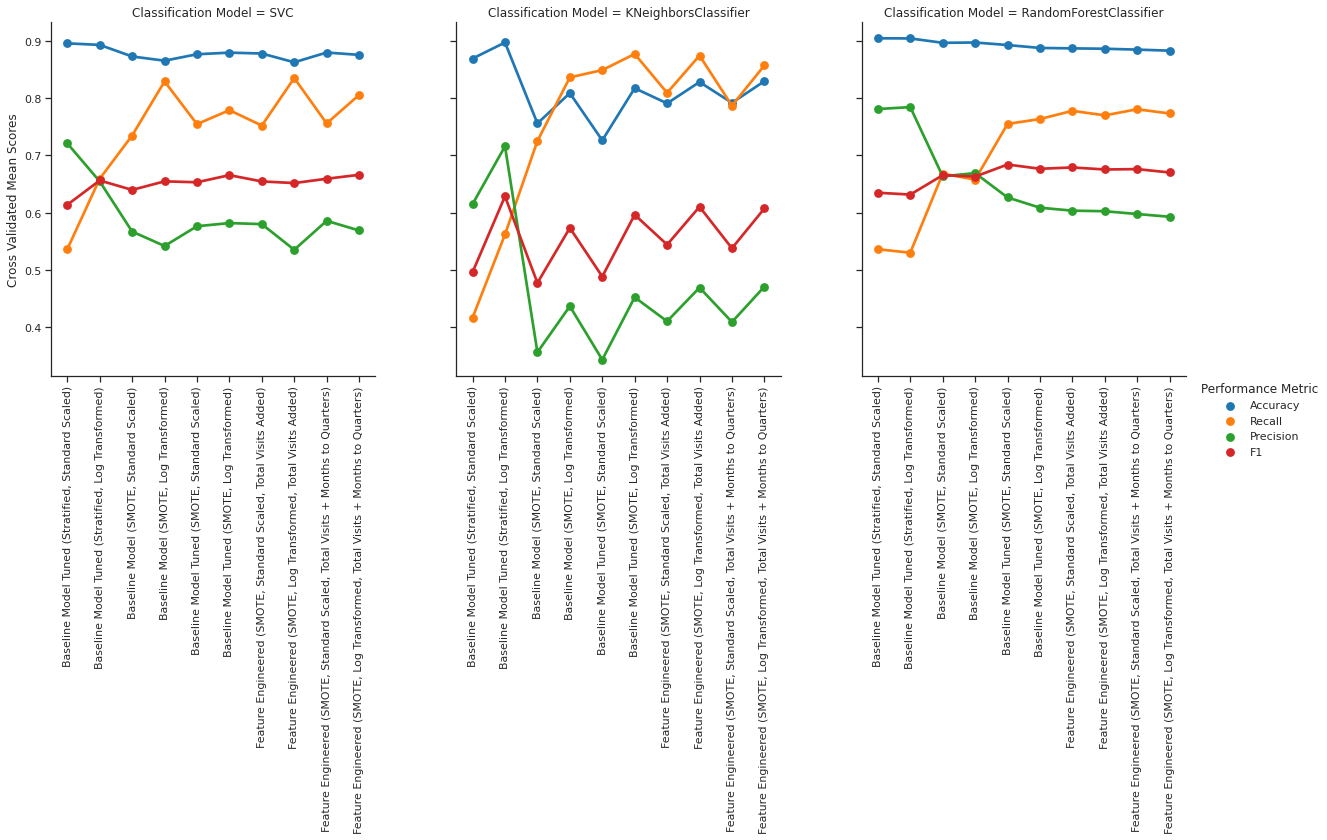

In [ ]:
plot_full_results(merged_scores)

In [ ]:
def pivot_full_results(final_scores_dict):
  final_df = pd.concat(list(final_scores_dict.values())).reset_index().drop("index", axis = 1)
  final_df.drop("Cross Validated SD Scores", axis = 1, inplace = True)
  k = pd.melt(final_df, id_vars = ["Performance Metric", "Classification Model", "Type"])
  final_results_df = k.pivot_table(index = ['Classification Model','Type'], columns = ["Performance Metric", "variable"], values = "value")
  return final_results_df

pivot_full_results(merged_scores)

Performance Metric                                                                           Accuracy  ...       Recall
variable                                                                  Cross Validated Mean Scores  ... Train Scores
Classification Model   Type                                                                            ...             
KNeighborsClassifier   Baseline Model (SMOTE, Log Transformed)                               0.809019  ...     0.997701
                       Baseline Model (SMOTE, Standard Scaled)                               0.756027  ...     0.995529
                       Baseline Model Tuned (SMOTE, Log Transformed)                         0.817561  ...     0.914282
                       Baseline Model Tuned (SMOTE, Standard Scaled)                         0.726394  ...     0.915687
                       Baseline Model Tuned (Stratified, Log Transformed)                    0.897506  ...     0.590433
                       Baseline Model Tuned (Stratified, Standard Scaled)                    0.869423  ...     0.621232
                       Feature Engineered (SMOTE, Log Transformed, Tot...                    0.829782  ...     0.890266
                       Feature Engineered (SMOTE, Log Transformed, Tot...                    0.828374  ...     0.905595
                       Feature Engineered (SMOTE, Standard Scaled, Tot...                    0.792040  ...     0.845043
                       Feature Engineered (SMOTE, Standard Scaled, Tot...                    0.791064  ...     0.877747
RandomForestClassifier Baseline Model (SMOTE, Log Transformed)                               0.897480  ...     1.000000
                       Baseline Model (SMOTE, Standard Scaled)                               0.896938  ...     1.000000
                       Baseline Model Tuned (SMOTE, Log Transformed)                         0.887962  ...     0.963720
                       Baseline Model Tuned (SMOTE, Standard Scaled)                         0.893045  ...     0.959888
                       Baseline Model Tuned (Stratified, Log Transformed)                    0.904603  ...     0.694626
                       Baseline Model Tuned (Stratified, Standard Scaled)                    0.904839  ...     0.737221
                       Feature Engineered (SMOTE, Log Transformed, Tot...                    0.883205  ...     0.961421
                       Feature Engineered (SMOTE, Log Transformed, Tot...                    0.886557  ...     0.972790
                       Feature Engineered (SMOTE, Standard Scaled, Tot...                    0.885042  ...     0.949157
                       Feature Engineered (SMOTE, Standard Scaled, Tot...                    0.887205  ...     0.960654
SVC                    Baseline Model (SMOTE, Log Transformed)                               0.865684  ...     0.871359
                       Baseline Model (SMOTE, Standard Scaled)                               0.873038  ...     0.908917
                       Baseline Model Tuned (SMOTE, Log Transformed)                         0.879743  ...     0.781937
                       Baseline Model Tuned (SMOTE, Standard Scaled)                         0.876931  ...     0.817067
                       Baseline Model Tuned (Stratified, Log Transformed)                    0.893282  ...     0.662516
                       Baseline Model Tuned (Stratified, Standard Scaled)                    0.896019  ...     0.625164
                       Feature Engineered (SMOTE, Log Transformed, Tot...                    0.875849  ...     0.811063
                       Feature Engineered (SMOTE, Log Transformed, Tot...                    0.862871  ...     0.855646
                       Feature Engineered (SMOTE, Standard Scaled, Tot...                    0.879960  ...     0.781170
                       Feature Engineered (SMOTE, Standard Scaled, Tot...                    0.878229  ...     0.795095

[30 rows x 12 columns]

In [ ]:
k = pivot_full_results(merged_scores)
# Zoom in on Random Forest cross-validated scores
k.loc["RandomForestClassifier",(["F1", "Accuracy", "Recall", "Precision"], ["Cross Validated Mean Scores"]), ].sort_values(("F1", "Cross Validated Mean Scores"), ascending = False)

Performance Metric,F1,Accuracy,Recall,Precision
variable,Cross Validated Mean Scores,Cross Validated Mean Scores,Cross Validated Mean Scores,Cross Validated Mean Scores
Type,,,,
"Baseline Model Tuned (SMOTE, Standard Scaled)",0.684172,0.893045,0.755125,0.626560
"Feature Engineered (SMOTE, Standard Scaled, Total Visits Added)",0.679039,0.887205,0.778002,0.603466
"Baseline Model Tuned (SMOTE, Log Transformed)",0.676674,0.887962,0.763674,0.608621
"Feature Engineered (SMOTE, Standard Scaled, Total Visits + Months to Quarters)",0.676091,0.885042,0.780762,0.597573
"Feature Engineered (SMOTE, Log Transformed, Total Visits Added)",0.675438,0.886557,0.770114,0.602482
"Feature Engineered (SMOTE, Log Transformed, Total Visits + Months to Quarters)",0.670219,0.883205,0.773361,0.592778
"Baseline Model (SMOTE, Standard Scaled)",0.665500,0.896938,0.668188,0.663499
"Baseline Model (SMOTE, Log Transformed)",0.663029,0.897480,0.657796,0.669121


In [ ]:
# Zoom in on SVC cross-validated scores
k.loc["SVC",(["F1", "Accuracy", "Recall", "Precision"], ["Cross Validated Mean Scores"]), ].sort_values(("F1", "Cross Validated Mean Scores"), ascending = False)

Performance Metric,F1,Accuracy,Recall,Precision
variable,Cross Validated Mean Scores,Cross Validated Mean Scores,Cross Validated Mean Scores,Cross Validated Mean Scores
Type,,,,
"Feature Engineered (SMOTE, Log Transformed, Total Visits + Months to Quarters)",0.666130,0.875849,0.805840,0.568783
"Baseline Model Tuned (SMOTE, Log Transformed)",0.665557,0.879743,0.779202,0.581752
"Feature Engineered (SMOTE, Standard Scaled, Total Visits + Months to Quarters)",0.659243,0.879960,0.755986,0.585721
"Baseline Model Tuned (Stratified, Log Transformed)",0.656258,0.893282,0.659266,0.654618
"Baseline Model (SMOTE, Log Transformed)",0.654712,0.865684,0.829483,0.541691
"Feature Engineered (SMOTE, Standard Scaled, Total Visits Added)",0.654573,0.878229,0.752266,0.579922
"Baseline Model Tuned (SMOTE, Standard Scaled)",0.653107,0.876931,0.754710,0.576243
"Feature Engineered (SMOTE, Log Transformed, Total Visits Added)",0.651713,0.862871,0.835353,0.535054


In [ ]:
# Zoom in on KNN cross-validated scores
k.loc["KNeighborsClassifier",(["F1", "Accuracy", "Recall", "Precision"], ["Cross Validated Mean Scores"]), ].sort_values(("F1", "Cross Validated Mean Scores"), ascending = False)

Performance Metric,F1,Accuracy,Recall,Precision
variable,Cross Validated Mean Scores,Cross Validated Mean Scores,Cross Validated Mean Scores,Cross Validated Mean Scores
Type,,,,
"Baseline Model Tuned (Stratified, Log Transformed)",0.628544,0.897506,0.561822,0.715981
"Feature Engineered (SMOTE, Log Transformed, Total Visits Added)",0.610259,0.828374,0.874654,0.468940
"Feature Engineered (SMOTE, Log Transformed, Total Visits + Months to Quarters)",0.607274,0.829782,0.857388,0.470561
"Baseline Model Tuned (SMOTE, Log Transformed)",0.596355,0.817561,0.877432,0.452015
"Baseline Model (SMOTE, Log Transformed)",0.573340,0.809019,0.836519,0.436404
"Feature Engineered (SMOTE, Standard Scaled, Total Visits Added)",0.543959,0.791064,0.809504,0.410010
"Feature Engineered (SMOTE, Standard Scaled, Total Visits + Months to Quarters)",0.537748,0.792040,0.786974,0.408762
"Baseline Model Tuned (Stratified, Standard Scaled)",0.495884,0.869423,0.416326,0.614977
